## FEATURE EXTRACTION

In [1]:
import warnings
from collections import Counter

import numpy as np
import pandas as pd
# from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from scipy.interpolate import NearestNDInterpolator
from scipy.ndimage import median_filter, gaussian_filter
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import silhouette_score
from tqdm import tqdm

from helper import *

In [2]:
# Create the data frames and save them if needed (BEWARE: this will overwrite the existing files and the process can take up to 2 hours)
import pandas as pd
import warnings
import numpy as np
from CreateTableOld import create_df
warnings.filterwarnings('ignore')
df1 = create_df("Dataset/DamasconeA/data2/*_CPXE_*.csv", offset=(49, 51), angle=1)
df2 = create_df("Dataset/DamasconeA/data1/*_CPXE_*.csv")
df3 = create_df("Dataset/DamasconeB/together/*_CPXE_*.csv", symmetric=True)

# Convert None to np.nan
df1 = df1.replace({None: np.nan})
df2 = df2.replace({None: np.nan})
df3 = df3.replace({None: np.nan})

df1.to_pickle("Dataset/DamasconeA2.pkl")
df2.to_pickle("Dataset/DamasconeA.pkl")
df3.to_pickle("Dataset/DamasconeB.pkl")

File Dataset/DamasconeA/data2\20250410_140819_HISTA_008_CPXE_2804.csv has no valid data after processing.
File Dataset/DamasconeA/data2\20250411_081343_HISTA_008_CPXE_6561.csv has no valid data after processing.
File Dataset/DamasconeA/data1\20250205_082609_HIST_006_CPXE_3.csv has no valid data after processing.
File Dataset/DamasconeB/together\20250210_123431_HISTB_001_CPXE_3799.csv has no valid data after processing.
File Dataset/DamasconeB/together\20250211_081453_HISTB_001_CPXE_6560.csv has no valid data after processing.


In [3]:
import pickle
import pandas as pd

data_train = pd.read_pickle("Dataset/DamasconeA2.pkl")
data_validation = pd.read_pickle("Dataset/DamasconeA.pkl")
data_test = pd.read_pickle("Dataset/DamasconeB.pkl")

In [4]:
import numpy as np

data_train['stiffness_to_relaxation'] = data_train['Stiffness'] / data_train['force_relaxation']
data_train['oscillation_to_max_force'] = data_train['force_oscillation'] / data_train['force_max']
data_train['strain_energy_density'] = data_train.apply(
    lambda row: row['energy_input'] / (np.max(row['Pi']) - np.min(row['Pi']))
    if len(row['Pi']) > 0 else np.nan,
    axis=1
)
data_train['energy_dissipation_ratio'] = data_train['hysteresis_area'] / data_train['energy_input']

data_test['stiffness_to_relaxation'] = data_test['Stiffness'] / data_test['force_relaxation']
data_test['oscillation_to_max_force'] = data_test['force_oscillation'] / data_test['force_max']
data_test['strain_energy_density'] = data_test.apply(
    lambda row: row['energy_input'] / (np.max(row['Pi']) - np.min(row['Pi']))
    if len(row['Pi']) > 0 else np.nan,
    axis=1
)
data_test['energy_dissipation_ratio'] = data_test['hysteresis_area'] / data_test['energy_input']

data_validation['stiffness_to_relaxation'] = data_validation['Stiffness'] / data_validation['force_relaxation']
data_validation['oscillation_to_max_force'] = data_validation['force_oscillation'] / data_validation['force_max']
data_validation['strain_energy_density'] = data_validation.apply(
    lambda row: row['energy_input'] / (np.max(row['Pi']) - np.min(row['Pi']))
    if len(row['Pi']) > 0 else np.nan,
    axis=1
)
data_validation['energy_dissipation_ratio'] = data_validation['hysteresis_area'] / data_validation['energy_input']

data_train['peak_position'] = - data_train['peak_position']
data_test['peak_position'] = - data_test['peak_position']
data_validation['peak_position'] = - data_validation['peak_position']



KeyboardInterrupt



In [ ]:
data_train = data_train.dropna()
data_test = data_test.dropna()
data_validation = data_validation.dropna()

In [19]:
from helper import feature_list2, feature_list_all, feature_optimal

to_remove = ['poly3_coef0', 'poly3_coef1', 'poly3_coef2', 'poly3_coef3',
             'poly4_coef0', 'poly4_coef1', 'poly4_coef2', 'poly4_coef3', 'poly4_coef4',
             'poly5_coef0', 'poly5_coef1', 'poly5_coef2', 'poly5_coef3', 'poly5_coef4',
             # Segmentation features
             'segment2_slope', 'segment3_slope', 'segment2_force_std', 'segment3_force_std',
             'segment2_skew', 'segment3_skew',"Force Steady State", "Power","Downstroke1","Dominant Frequency",
             "offset", "force_max", "wavelet_energy_0", "wavelet_energy_1", "wavelet_energy_2",
            "wavelet_energy_3", "wavelet_energy_4", "stft_mean_freq",
            "imf_energy_0", "imf_energy_1", "imf_energy_2","energy_input", "jerk_max", "zero_crossings_force", "zero_crossings_position",
              "stiffness_ratio", "force_oscillation", "spectral_centroid_force", "spectral_entropy_force", "spectral_centroid_position",
            "spectral_entropy_position", "impedance_ratio_lowfreq", "coherence_LF", "coherence_HF","peak_width", "adhesion_energy","max_pos_rate",
             "unload_duration", "load_unload_ratio","loading_slope", "unloading_slope", "slope_symmetry",
            "curvature_peak", "slope_log_log","complexity_value", "hurst_exp","position_relaxation","perm_entropy",'oscillation_to_max_force','stiffness_to_relaxation',"peak_position", "hysteresis_area","energy_dissipation_ratio", "loading_energy", "loading_nonlinearity","loading_unloading_area_ratio", "force_ratio_75_25",'local_mean_Downstroke1', 'local_mean_Stiffness','local_mean_Downstroke2',
             'local_mean_time_to_max',
            'local_std_Stiffness', 'local_std_Upstroke', 'local_std_Downstroke1', 'local_std_Downstroke2', 'local_std_Tau', 'local_std_time_to_max',
            'local_skewness_Stiffness', 'local_skewness_Upstroke', 'local_skewness_Downstroke1', 'local_skewness_Downstroke2', 'local_skewness_Tau', 'local_skewness_time_to_max',
            'local_kurtosis_Stiffness', 'local_kurtosis_Upstroke', 'local_kurtosis_Downstroke1', 'local_kurtosis_Downstroke2', 'local_kurtosis_Tau', 'local_kurtosis_time_to_max',
            'local_range_Stiffness', 'local_range_Upstroke', 'local_range_Downstroke1', 'local_range_Downstroke2', 'local_range_Tau', 'local_range_time_to_max',
            'local_gradient_norm_Stiffness', 'local_gradient_norm_Upstroke', 'local_gradient_norm_Downstroke1', 'local_gradient_norm_Downstroke2', 'local_gradient_norm_Tau', 'local_gradient_norm_time_to_max',
             'stiffness_deviation_from_global', 'position_deviation_from_global',
              # Sobel gradient features
            'sobel_gradient_magnitude_Stiffness', 'sobel_gradient_magnitude_Upstroke', 'sobel_gradient_magnitude_Downstroke1', 'sobel_gradient_magnitude_Downstroke2', 'sobel_gradient_magnitude_Tau', 'sobel_gradient_magnitude_time_to_max',
            'sobel_gradient_direction_Stiffness', 'sobel_gradient_direction_Upstroke', 'sobel_gradient_direction_Downstroke1', 'sobel_gradient_direction_Downstroke2', 'sobel_gradient_direction_Tau', 'sobel_gradient_direction_time_to_max',

            # Laplacian features
            'laplacian_Stiffness', 'laplacian_Upstroke', 'laplacian_Downstroke1', 'laplacian_Downstroke2', 'laplacian_Tau', 'laplacian_time_to_max',


            # LBP features for two parameter sets: P=8,R=1 and P=16,R=2
            'lbp_code_P8_R1', 'lbp_code_P16_R2',
            'lbp_bin1_P8_R1', 'lbp_bin2_P8_R1', 'lbp_bin3_P8_R1',
            'lbp_val1_P8_R1', 'lbp_val2_P8_R1', 'lbp_val3_P8_R1',
            'lbp_mean_P8_R1', 'lbp_std_P8_R1', 'lbp_entropy_P8_R1',
            'lbp_bin1_P16_R2', 'lbp_bin2_P16_R2', 'lbp_bin3_P16_R2',
            'lbp_val1_P16_R2', 'lbp_val2_P16_R2', 'lbp_val3_P16_R2',
            'lbp_mean_P16_R2', 'lbp_std_P16_R2', 'lbp_entropy_P16_R2',
             # Structure tensor features
            'structure_tensor_coherence', 'structure_tensor_orientation',
            'structure_tensor_lambda1', 'structure_tensor_lambda2',

            # Phase congruency features
            'phase_congruency_w3', 'phase_congruency_w5', 'phase_congruency_w7',

            # Distance weighted relationship features
            'distance_weighted_diff', 'boundary_likelihood',

            # Multi-scale edge response features
            'edge_response_scale1', 'edge_response_scale2', 'edge_response_scale3',

            # Local contrast normalization features (for each feature in features_list, multiple window sizes)
            'Stiffness_range_norm_w3', 'Stiffness_range_norm_w5', 'Stiffness_range_norm_w7', 'Stiffness_range_norm_w9',
            'Upstroke_range_norm_w3', 'Upstroke_range_norm_w5', 'Upstroke_range_norm_w7', 'Upstroke_range_norm_w9',
            'Downstroke1_range_norm_w3', 'Downstroke1_range_norm_w5', 'Downstroke1_range_norm_w7', 'Downstroke1_range_norm_w9',
            'Downstroke2_range_norm_w3', 'Downstroke2_range_norm_w5', 'Downstroke2_range_norm_w7', 'Downstroke2_range_norm_w9',
            'Tau_range_norm_w3', 'Tau_range_norm_w5', 'Tau_range_norm_w7', 'Tau_range_norm_w9',
            'time_to_max_range_norm_w3', 'time_to_max_range_norm_w5', 'time_to_max_range_norm_w7', 'time_to_max_range_norm_w9',

            # Center-surround difference features
            'center_surround_diff_c1_s3', 'center_surround_diff_c1_s5', 'center_surround_diff_c2_s3', 'center_surround_diff_c2_s5',
            'center_surround_ratio_c1_s3', 'center_surround_ratio_c1_s5', 'center_surround_ratio_c2_s3', 'center_surround_ratio_c2_s5',
            'center_surround_contrast_c1_s3', 'center_surround_contrast_c1_s5', 'center_surround_contrast_c2_s3', 'center_surround_contrast_c2_s5',

            # Local surface metrics
            'local_Ra_w3', 'local_Ra_w5', 'local_Ra_w7',
            'local_Rq_w3', 'local_Rq_w5', 'local_Rq_w7',
            'local_skewness_w3', 'local_skewness_w5', 'local_skewness_w7',
            'local_kurtosis_w3', 'local_kurtosis_w5', 'local_kurtosis_w7',
            'local_peak_height_w3', 'local_peak_height_w5', 'local_peak_height_w7',
            'local_valley_depth_w3', 'local_valley_depth_w5', 'local_valley_depth_w7',

             # Local stiffness anomaly features
            'local_stiffness_w3', 'local_stiffness_w5', 'local_stiffness_w7',
            'local_stiffness_zscore_w3', 'local_stiffness_zscore_w5', 'local_stiffness_zscore_w7',

            # Spatial pattern features
            'stiffness_harris_response', 'stiffness_edge_response',

            # Surface curvature features
            'surface_mean_curvature', 'surface_gaussian_curvature', 'surface_type',

            # Morphological features (for each threshold)
            'morph_area_mean_t0', 'morph_area_mean_t1', 'morph_area_mean_t2', 'morph_area_mean_t3',
            'morph_area_std_t0', 'morph_area_std_t1', 'morph_area_std_t2', 'morph_area_std_t3',
            'morph_perimeter_mean_t0', 'morph_perimeter_mean_t1', 'morph_perimeter_mean_t2', 'morph_perimeter_mean_t3',
            'morph_perimeter_std_t0', 'morph_perimeter_std_t1', 'morph_perimeter_std_t2', 'morph_perimeter_std_t3',
            'morph_euler_mean_t0', 'morph_euler_mean_t1', 'morph_euler_mean_t2', 'morph_euler_mean_t3',
            'morph_active_ratio_t0', 'morph_active_ratio_t1', 'morph_active_ratio_t2', 'morph_active_ratio_t3',
            'morph_border_touch_ratio_t0', 'morph_border_touch_ratio_t1', 'morph_border_touch_ratio_t2', 'morph_border_touch_ratio_t3',

            # Position context features
            'dist_to_grid_edge', 'is_grid_corner'

             ]
feature_list_3 = feature_list = [x for x in feature_list2  if x not in to_remove]
#feature_list = [x for x in feature_optimal if x not in to_remove]

# feature_list = feature_list_3
# feature_list = ['loading_unloading_area_ratio', 'peak_width', 'stiffness_to_relaxation', 'Stiffness']
# feature_list = ["Stiffness", "Upstroke", "Downstroke", "P_ss"] #, "P_ss", "loading_energy"]peak_position

# feature_list = ['poly4_coef4', 'poly4_coef3', 'poly5_coef0', 'loading_unloading_area_ratio', 'Stiffness', 'quartic_coefficient', 'Upstroke']

In [ ]:
# Get column names from your data
data_columns = set(data_train.columns)
feature_list_set = set(feature_list)
print(feature_list)
print(f"Feature list: {len(feature_list)}")
# Find columns that are in the data but not in feature_list
extra_columns = data_columns - feature_list_set
print(f"Columns in data but not in feature_list ({len(extra_columns)}):")
print(sorted(extra_columns))

### VISUALIZATION OF FEATURE

In [ ]:
from plotter import plot_features_singledf
print("DATA TRAIN")
plot_features_singledf(data_train, feature_list=feature_list)

In [ ]:
print("DATA VALIDATION")
plot_features_singledf(data_validation, feature_list=feature_list)

In [ ]:
print("DATA TEST")
plot_features_singledf(data_test, feature_list=feature_list)

### SPATIAL SMOOTHING

In [6]:
from scipy.interpolate import NearestNDInterpolator
from scipy.ndimage import median_filter, gaussian_filter
from helper import *

smoothing_config = {
    'Entropy': 'gaussian',
}  # Dictionary 'feature-name' : type of smoothing (set if you want to test other method of smoothing instead of median)


def apply_smoothing(grid_z, method='median'):
    if method == 'median':
        return median_filter(grid_z, size=3, mode='reflect')
    elif method == 'gaussian':
        return gaussian_filter(grid_z, sigma=2)
    elif method == 'diffusion':
        # Simple anisotropic diffusion
        def diffusion_step(img, kappa=50):
            # Compute image gradients
            dy, dx = np.gradient(img)

            # Compute diffusion coefficients
            diff_coef_x = 1 / (1 + (dx / kappa) ** 2)
            diff_coef_y = 1 / (1 + (dy / kappa) ** 2)

            # Compute diffusion
            diff_x = np.zeros_like(img)
            diff_y = np.zeros_like(img)

            diff_x[1:-1, 1:-1] = diff_coef_x[1:-1, 1:-1] * (img[1:-1, 2:] - img[1:-1, 1:-1])
            diff_y[1:-1, 1:-1] = diff_coef_y[1:-1, 1:-1] * (img[2:, 1:-1] - img[1:-1, 1:-1])

            return img + 0.25 * (diff_x + diff_y)

        # Apply multiple diffusion steps
        iterations = 20
        img = grid_z.copy()
        for i in range(iterations):
            img = diffusion_step(img)
        return img

    else:
        raise ValueError(f"Smoothing method not implemented: {method}")


def get_grid_bounds(df):
    x_min, x_max = int(df["posx"].min()), int(df["posx"].max())
    y_min, y_max = int(df["posy"].min()), int(df["posy"].max())
    grid_shape = (y_max - y_min + 1, x_max - x_min + 1)
    return x_min, y_min, grid_shape


# Smoothing function for a single dataframe
def smooth_subset(subset_df, x_min, y_min, grid_shape):
    smoothed_subset = pd.DataFrame(index=subset_df.index)

    for feature in feature_list:
        # Initialize grid with NaNs
        grid_z = np.full(grid_shape, np.nan, dtype=np.float32)

        # Map each data point to the grid
        for _, row in subset_df.iterrows():
            x_idx = int(row["posx"]) - x_min
            y_idx = int(row["posy"]) - y_min
            grid_z[y_idx, x_idx] = row[feature]

        # Interpolate missing values
        yy, xx = np.indices(grid_z.shape)
        valid_mask = ~np.isnan(grid_z)

        if np.any(~valid_mask):
            interpolator = NearestNDInterpolator(
                np.column_stack((yy[valid_mask], xx[valid_mask])),
                grid_z[valid_mask]
            )
            grid_z = interpolator(yy, xx)

        # Apply feature-specific smoothing
        methods = smoothing_config.get(feature,
                                       'median')  # Get the designed methods, if None select defaul 'median' method
        if isinstance(methods, list):
            for method in methods:
                grid_z = apply_smoothing(grid_z, method=method)
        else:
            grid_z = apply_smoothing(grid_z, method=methods)

        # Map smoothed grid back to DataFrame
        smoothed_subset[feature] = [
            grid_z[int(row["posy"]) - y_min, int(row["posx"]) - x_min]
            for _, row in subset_df.iterrows()
        ]

    # Add back metadata columns
    smoothed_subset[['label', 'posx', 'posy']] = subset_df[['label', 'posx', 'posy']]
    return smoothed_subset


if smoothing_config is None:
    smoothing_config = {feature: 'median' for feature in feature_list}

# Compute grid bounds and smooth each subset
test_x_min, test_y_min, test_grid_shape = get_grid_bounds(data_test)
train_x_min, train_y_min, train_grid_shape = get_grid_bounds(data_train)
val_x_min, val_y_min, val_grid_shape = get_grid_bounds(data_validation)

# Smooth each subset SEPARATELY
smoothed_test = smooth_subset(data_test, test_x_min, test_y_min, test_grid_shape)
smoothed_train = smooth_subset(data_train, train_x_min, train_y_min, train_grid_shape)
smoothed_validation = smooth_subset(data_validation, val_x_min, val_y_min, val_grid_shape)

smoothed_df = pd.concat([smoothed_test, smoothed_train], ignore_index=True)

## DB SPLITTING

### Binary Classifier

Class distribution in the dataset:
Label 0: 4608 samples (35.13%)
Label 1: 395 samples (3.01%)
Label 2: 391 samples (2.98%)
Label 3: 378 samples (2.88%)
Label 4: 391 samples (2.98%)
Label 5: 396 samples (3.02%)
Class distribution in the dataset:
Label 0: 4613 samples (35.17%)
Label 1: 388 samples (2.96%)
Label 2: 387 samples (2.95%)
Label 3: 393 samples (3.00%)
Label 4: 388 samples (2.96%)
Label 5: 388 samples (2.96%)


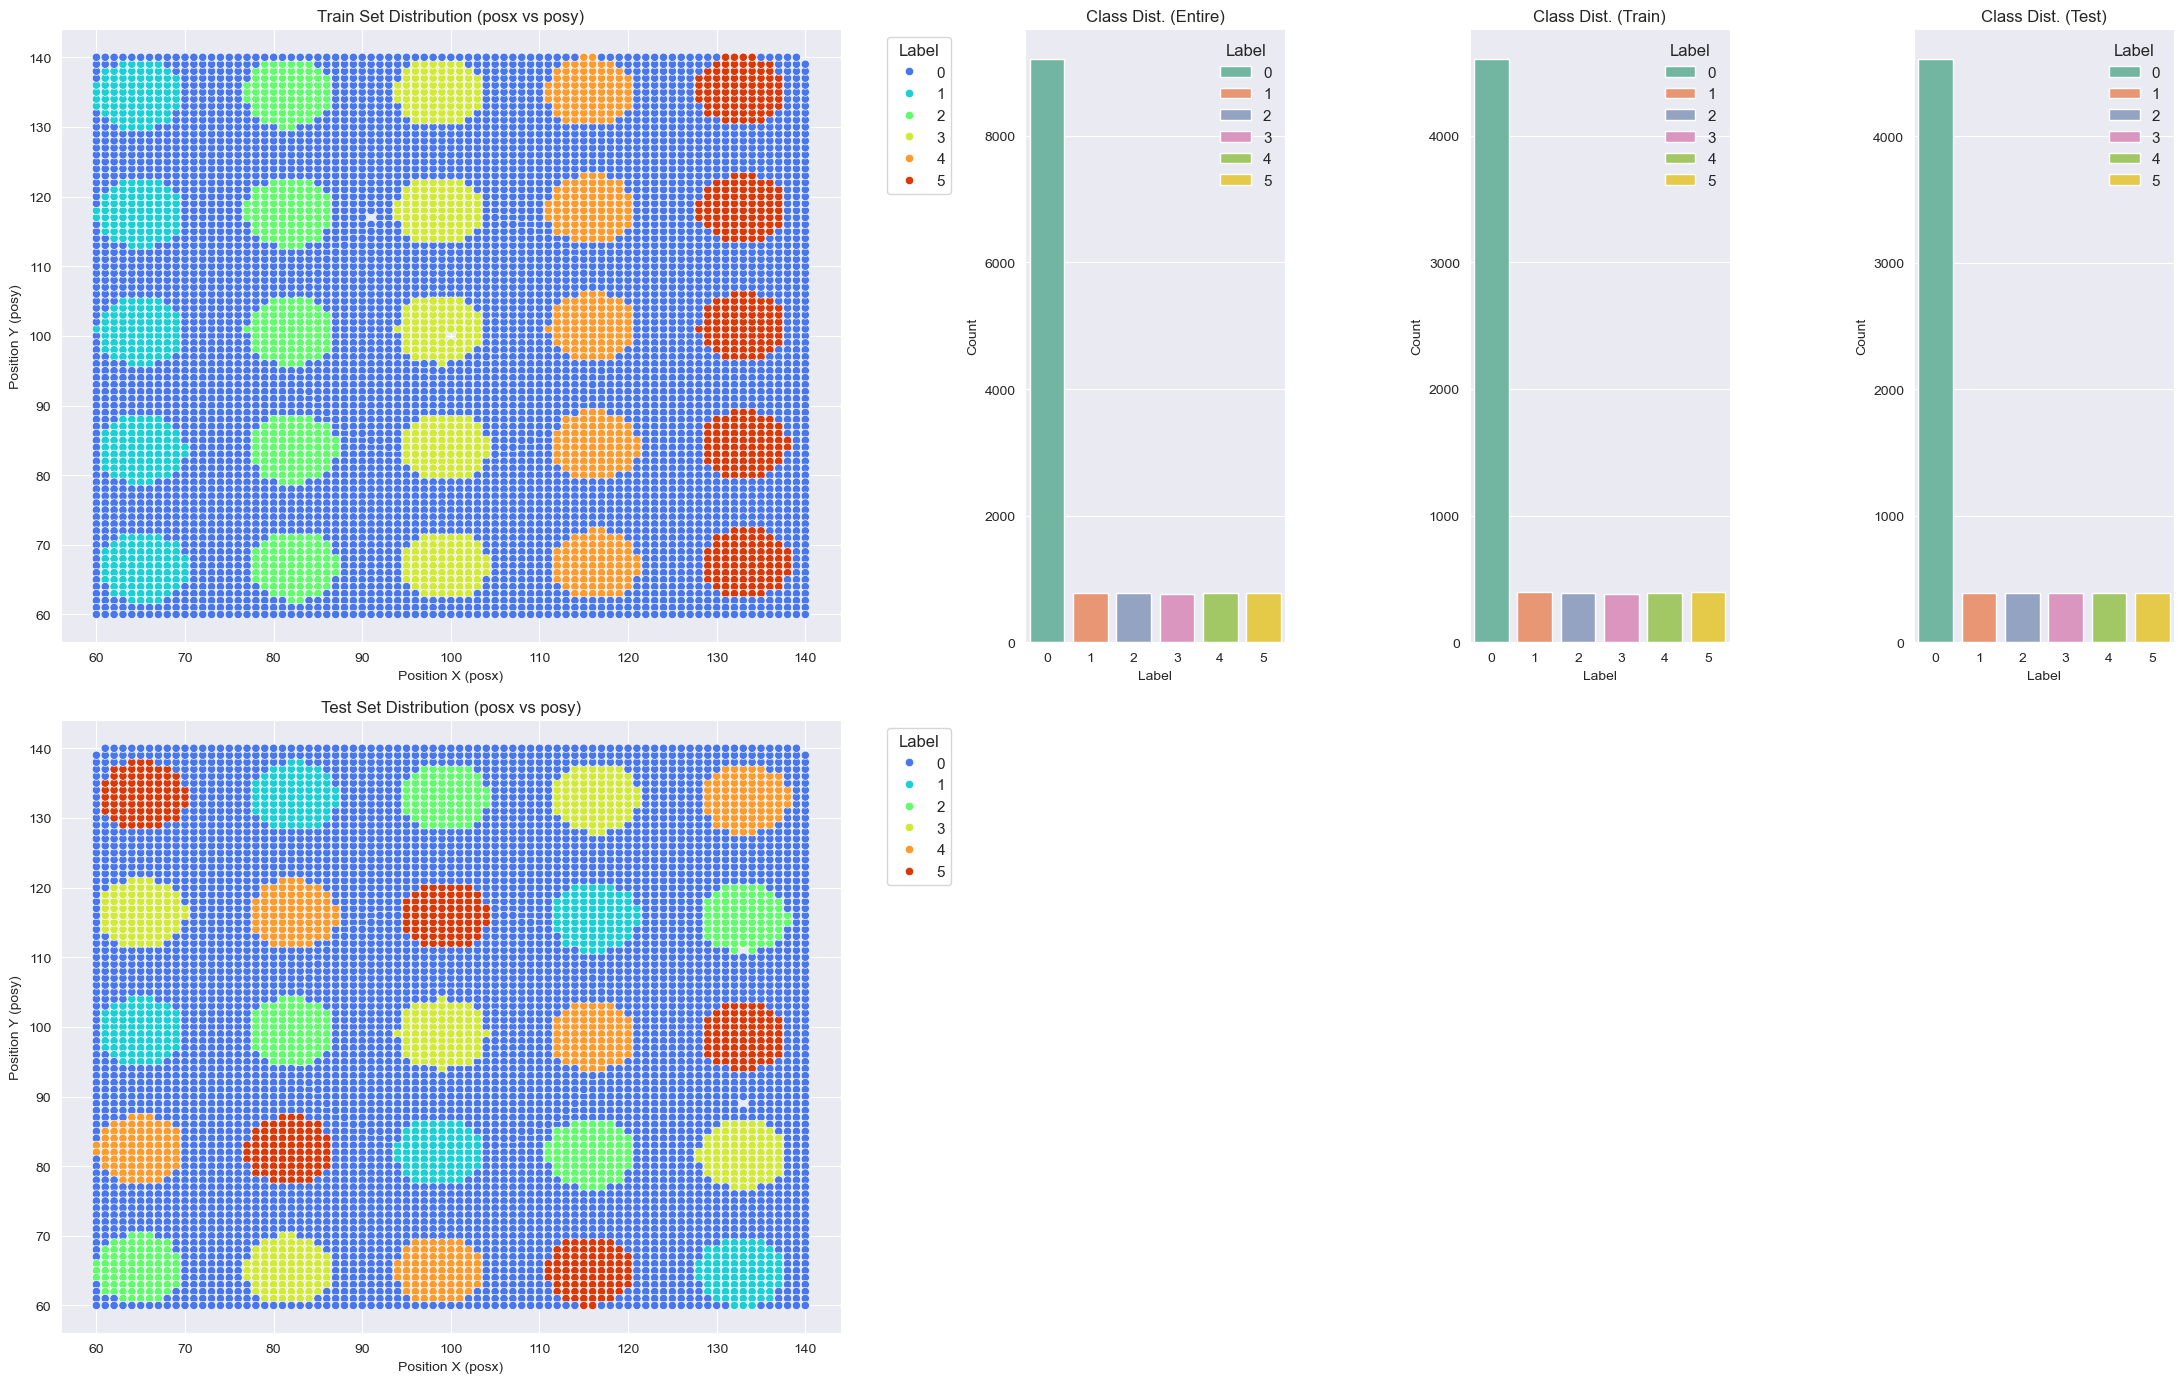

In [7]:
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# Display class distribution
X = smoothed_df[feature_list + ["posx", "posy"]]
y = smoothed_df['label']

# train_df = pd.concat([train_df1, train_df2], ignore_index=True)
# smoothed_train = pd.concat([smoothed_train1, smoothed_train2], ignore_index=True)

# Training distribution:
class_distribution = Counter(smoothed_train['label'])
print("Class distribution in the dataset:")
for label, count in sorted(class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y) * 100:.2f}%)")

# Test distribution:
class_distribution = Counter(smoothed_test['label'])
print("Class distribution in the dataset:")
for label, count in sorted(class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y) * 100:.2f}%)")

# Prepare data for classification
X_train = smoothed_train[feature_list + ["posx", "posy"]]
y_train = smoothed_train['label']

X_test = smoothed_test[feature_list + ["posx", "posy"]]
y_test = smoothed_test['label']

X_validation = smoothed_validation[feature_list + ["posx", "posy"]]
y_validation = smoothed_validation['label']

# Create the figure and axes: 2 rows (train/test), then 3 histograms
fig, axs = plt.subplots(2, 4, figsize=(22, 14), gridspec_kw={'width_ratios': [3, 1, 1, 1]})

# Set style
sns.set(style="whitegrid")

# Create consistent color map using turbo
unique_labels = sorted(data_train['label'].unique())  # or union of train + test if needed
palette_colors = sns.color_palette("turbo", n_colors=len(unique_labels))
label_color_dict = {label: color for label, color in zip(unique_labels, palette_colors)}

# Plot train
sns.scatterplot(
    data=data_train,
    x='posx',
    y='posy',
    hue='label',
    palette=label_color_dict,  # Use fixed mapping
    ax=axs[0, 0]
)
axs[0, 0].set_title("Train Set Distribution (posx vs posy)")
axs[0, 0].set_xlabel("Position X (posx)")
axs[0, 0].set_ylabel("Position Y (posy)")
axs[0, 0].legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot test with same label-color mapping
sns.scatterplot(
    data=data_test,
    x='posx',
    y='posy',
    hue='label',
    palette=label_color_dict,  # Same dictionary ensures color consistency
    ax=axs[1, 0]
)
axs[1, 0].set_title("Test Set Distribution (posx vs posy)")
axs[1, 0].set_xlabel("Position X (posx)")
axs[1, 0].set_ylabel("Position Y (posy)")
axs[1, 0].legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Histograms / Class Distribution Plots ---
plot_class_distribution(smoothed_df['label'], axs[0, 1], "Class Dist. (Entire)")
plot_class_distribution(y_train, axs[0, 2], "Class Dist. (Train)")
plot_class_distribution(y_test, axs[0, 3], "Class Dist. (Test)")

# Hide the unused bottom row histograms
for ax in axs[1, 1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# # Drop posx and posy columns from the training and testing sets after plotting
# X_train = X_train.drop(columns=['posx', 'posy'])
# X_test = X_test.drop(columns=['posx', 'posy'])

In [8]:
from sklearn.preprocessing import StandardScaler

scaler_train1 = StandardScaler()
scaler_train2 = StandardScaler()
scaler_test = StandardScaler()

X_train_selected = X_train[feature_list]
X_test_selected = X_test[feature_list]
X_validation_selected = X_validation[feature_list]

# X_train_selected_1 = X_train_selected[X_train["posy"] <= 140]
# X_train_selected_2 = X_train_selected[X_train["posy"] > 140]

X_train_scaled = scaler_train1.fit_transform(X_train_selected)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_list, index=X_train_selected.index)

X_validation_scaled = scaler_train1.fit_transform(X_validation_selected)
X_validation_scaled = pd.DataFrame(X_validation_scaled, columns=feature_list, index=X_validation_selected.index)

# X_train_scaled2 = scaler_train2.fit_transform(X_train_selected_2)

# X_train_scaled1 = pd.DataFrame(X_train_scaled1, columns=feature_list, index=X_train_selected_1.index)
# X_train_scaled2 = pd.DataFrame(X_train_scaled2, columns=feature_list, index=X_train_selected_2.index)
# X_train_scaled = pd.concat([X_train_scaled1, X_train_scaled2]).sort_index()

X_test_scaled = scaler_test.fit_transform(X_test_selected)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_list, index=X_test_selected.index)

Plotting overall feature importance...


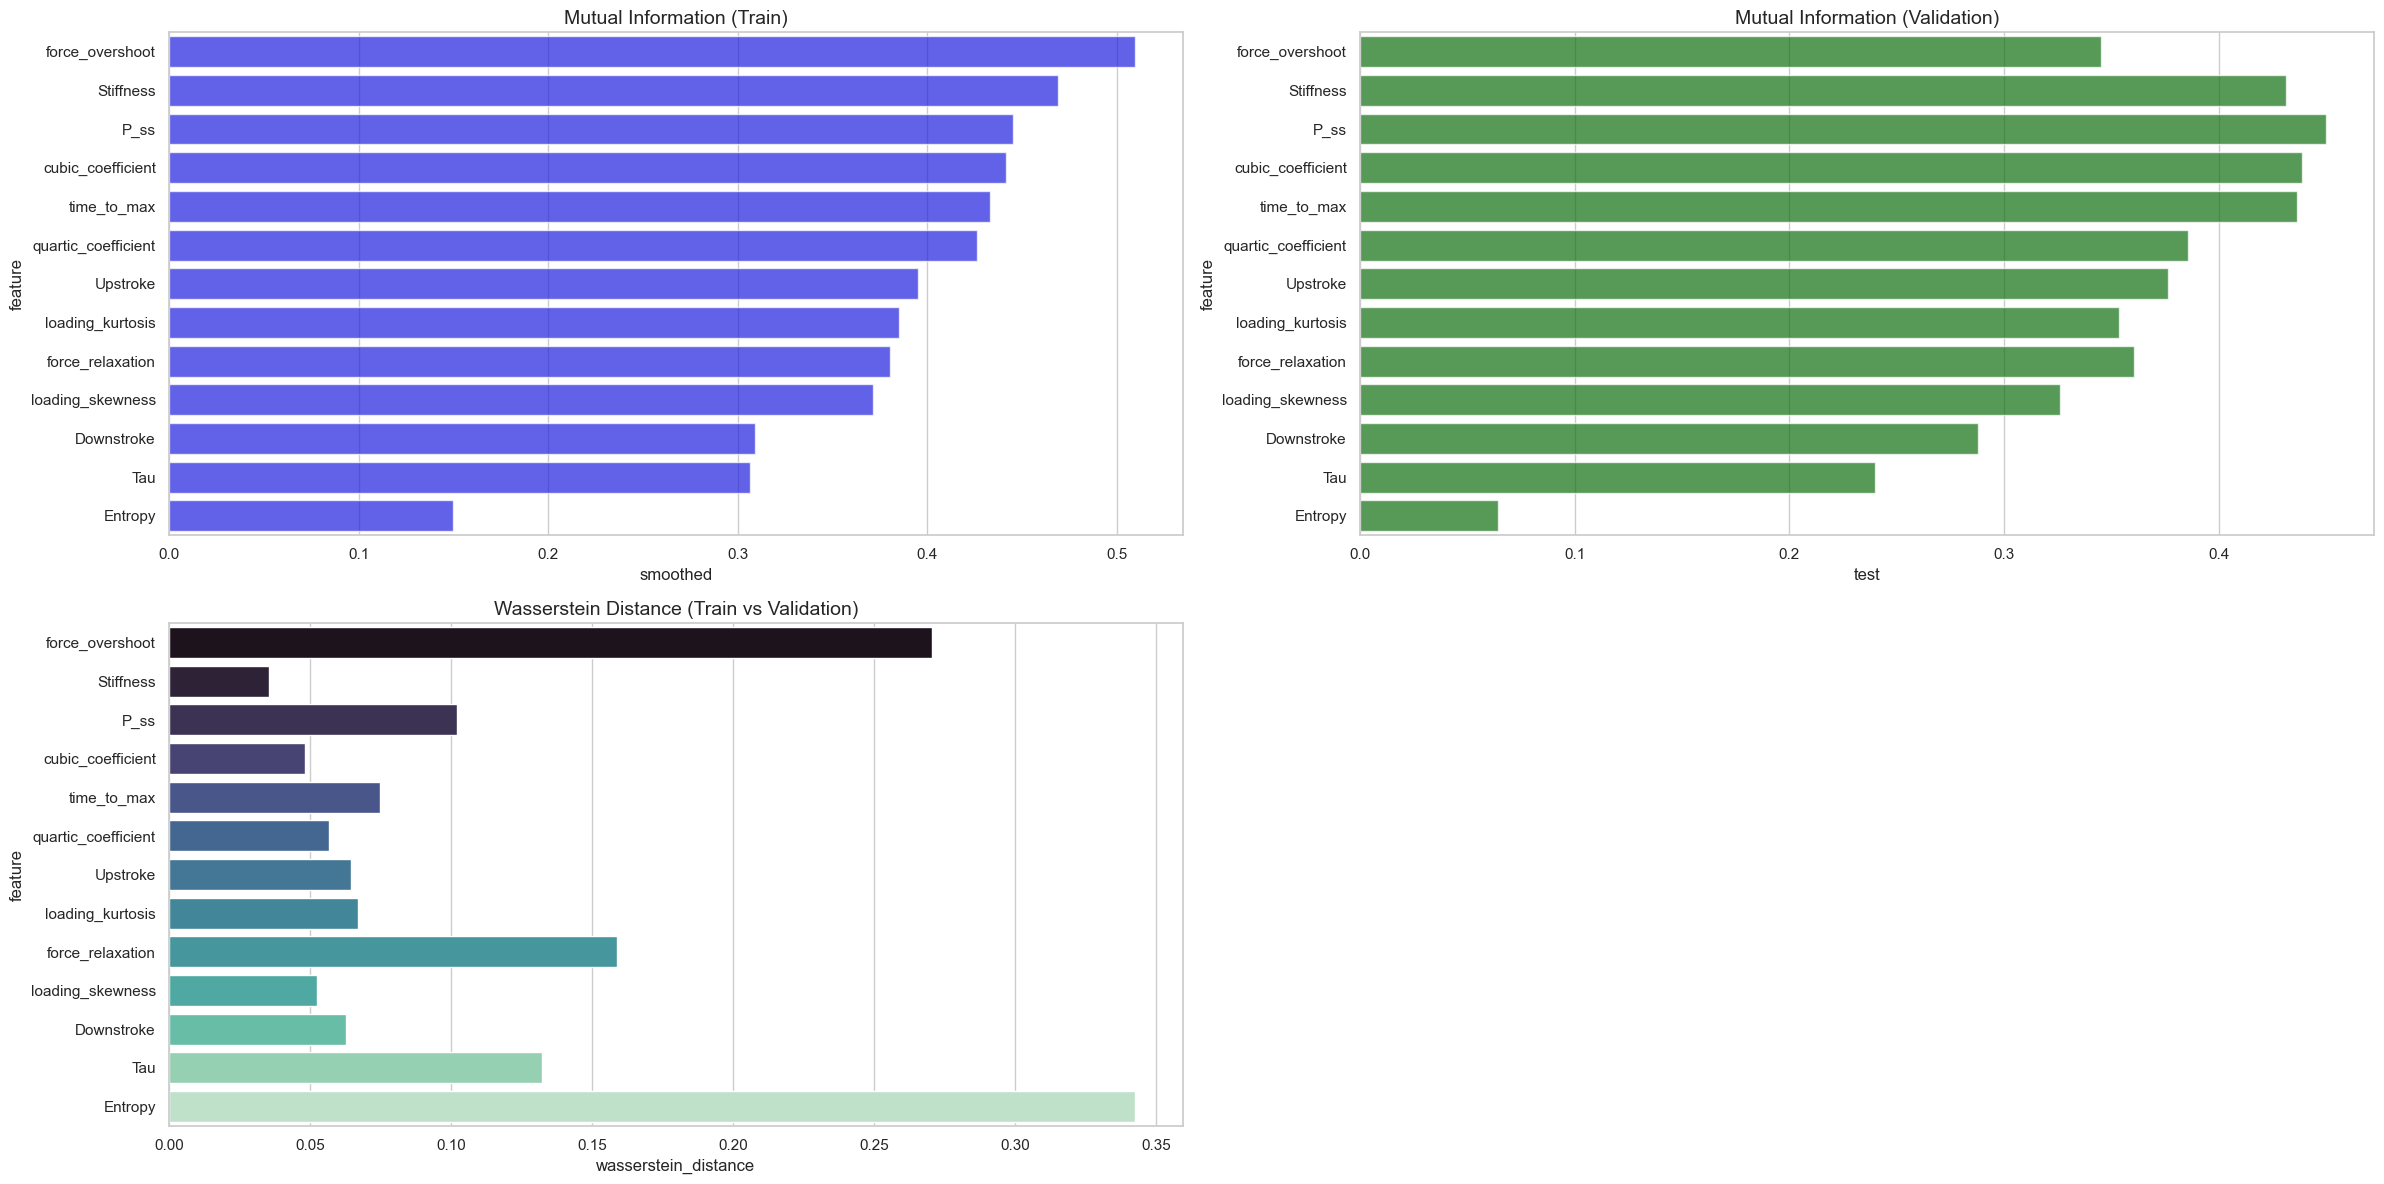

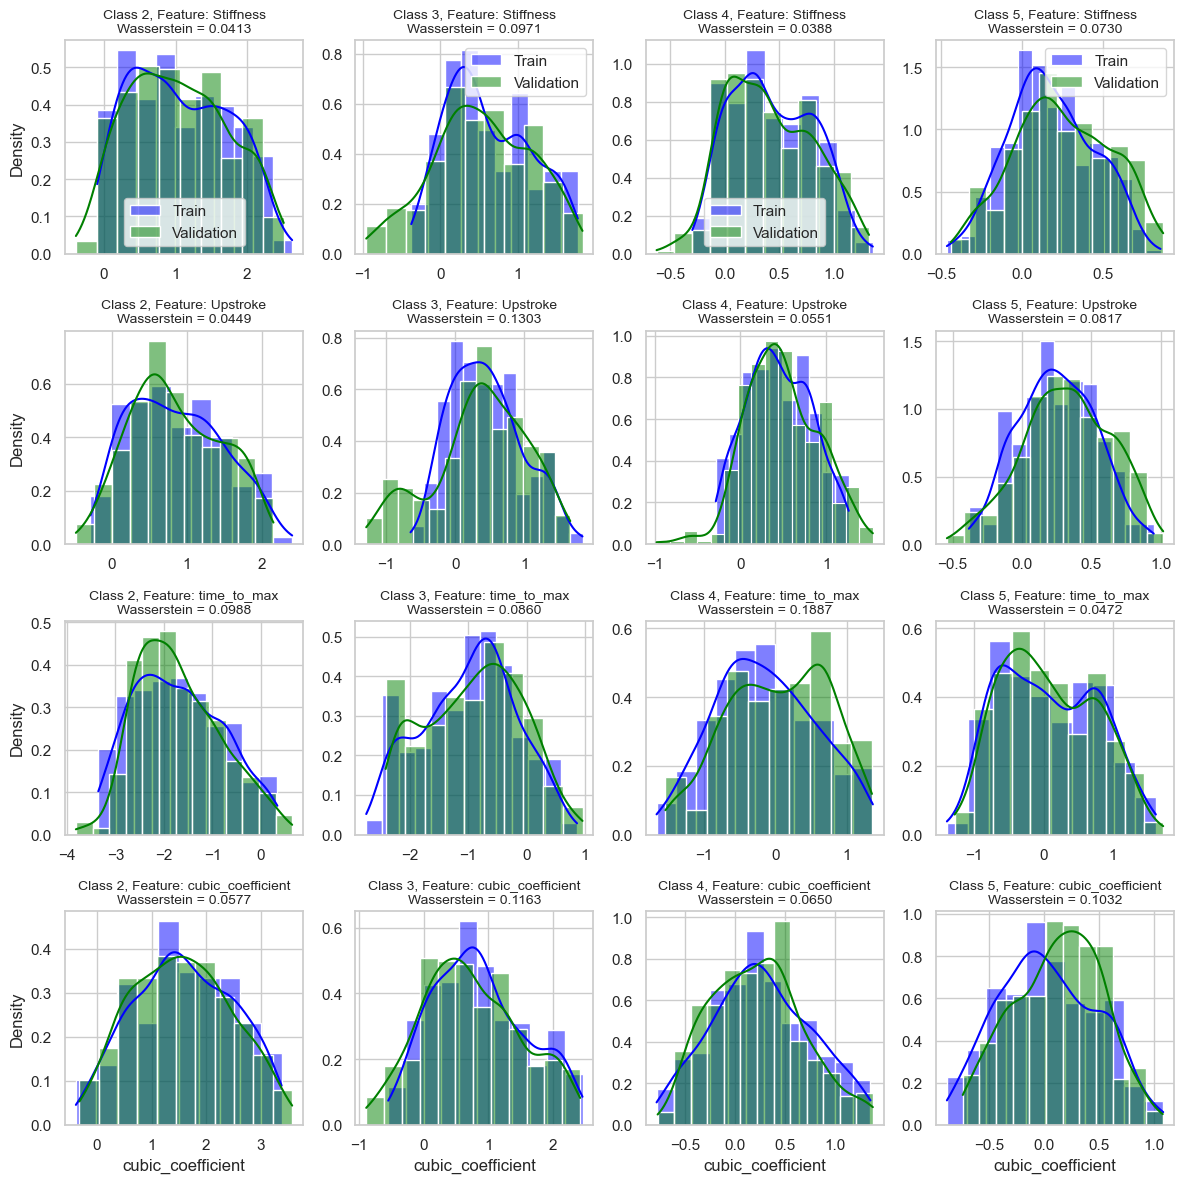


✅ Selected Features (4):
  - MI threshold: 0.3
  - Wasserstein threshold: 0.275
  - Per-class Wasserstein threshold: 0.2
  1. Stiffness
  2. Upstroke
  3. time_to_max
  4. cubic_coefficient


In [9]:
def calculate_mutual_info(X_data, y_data, feature_list, random_state=42):
    """Calculate mutual information scores for features."""
    return mutual_info_classif(X_data[feature_list], y_data, random_state=random_state)


def calculate_wasserstein_distances(train_data, validation_data, feature_list):
    """Calculate Wasserstein distance between train and validation for each feature."""
    distances = []

    for feature in feature_list:
        distance = wasserstein_distance(train_data[feature], validation_data[feature])
        distances.append({'feature': feature, 'wasserstein_distance': distance})

    return pd.DataFrame(distances)


def calculate_distribution_metrics(train_data, validation_data, feature_list):
    """Calculate distribution metrics between train and validation sets."""
    metrics = []

    for feature in feature_list:
        # Wasserstein distance (Earth Mover's Distance)
        w_distance = wasserstein_distance(train_data[feature], validation_data[feature])

        # Kolmogorov-Smirnov test
        ks_stat, ks_pval = ks_2samp(train_data[feature], validation_data[feature])

        metrics.append({
            'feature': feature,
            'wasserstein_distance': w_distance,
            'ks_statistic': ks_stat,
            'ks_pvalue': ks_pval
        })

    return pd.DataFrame(metrics)


def calculate_class_distribution_metrics(X_train, y_train, X_validation, y_validation, feature_list, selected_classes):
    """Calculate distribution metrics for each selected class."""
    class_metrics = {}

    for cls in selected_classes:
        # Filter data for this class
        X_train_cls = X_train[y_train == cls]
        X_val_cls = X_validation[y_validation == cls]

        # Calculate metrics for this class
        metrics_df = calculate_distribution_metrics(X_train_cls, X_val_cls, feature_list)
        class_metrics[cls] = metrics_df

    return class_metrics


def plot_feature_importance(mi_df, metrics_df, figsize=(24, 12)):
    """Plot mutual information and distribution metrics for features."""
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Ensure both dataframes have the same feature ordering
    mi_df = mi_df.sort_values('smoothed', ascending=False)

    # Merge to maintain the same order
    merged_df = mi_df[['feature']].merge(metrics_df, on='feature')

    # Plot Mutual Information
    sns.barplot(x='smoothed', y='feature', data=mi_df.head(15),
                color='blue', alpha=0.7, ax=axes[0, 0])
    sns.barplot(x='test', y='feature', data=mi_df.head(15),
                color='green', alpha=0.7, ax=axes[0, 1])

    axes[0, 0].set_title('Mutual Information (Train)', fontsize=14)
    axes[0, 1].set_title('Mutual Information (Validation)', fontsize=14)

    # Plot Wasserstein Distance only
    sns.barplot(x='wasserstein_distance', y='feature', data=merged_df.head(15),
                palette='mako', ax=axes[1, 0], hue='feature')
    axes[1, 0].set_title('Wasserstein Distance (Train vs Validation)', fontsize=14)

    # Turn off the unused subplot
    axes[1, 1].axis('off')

    plt.tight_layout()
    return fig


def visualize_feature_distributions(X_train, y_train, X_validation, y_validation,
                                    selected_features, selected_classes):
    figsize = (3 * len(selected_classes), 3 * len(selected_features))
    fig, axes = plt.subplots(len(selected_features), len(selected_classes), figsize=figsize)

    for i, feature in enumerate(selected_features):
        for j, cls in enumerate(selected_classes):
            ax = axes[i, j] if len(selected_features) > 1 else axes[j]

            # Filter data for the class
            train_data = X_train[y_train == cls][feature]
            val_data = X_validation[y_validation == cls][feature]

            # Plot distributions
            sns.histplot(train_data, kde=True, color='blue', alpha=0.5,
                         ax=ax, label='Train', stat='density')
            sns.histplot(val_data, kde=True, color='green', alpha=0.5,
                         ax=ax, label='Validation', stat='density')

            # Calculate Wasserstein distance for this feature and class
            w_dist = wasserstein_distance(train_data, val_data)

            ax.set_title(f"Class {cls}, Feature: {feature}\nWasserstein = {w_dist:.4f}", fontsize=10)

            if i == 0:
                ax.legend()

            if i == len(selected_features) - 1:
                ax.set_xlabel(feature)
            else:
                ax.set_xlabel('')

            if j == 0:
                ax.set_ylabel('Density')
            else:
                ax.set_ylabel('')

    plt.tight_layout()
    return fig


def select_features_advanced(mi_df, metrics_df, class_metrics, selected_classes,
                             mi_threshold=0.5, wasserstein_threshold=0.12,
                             class_wasserstein_threshold=None):
    """
    Select features based on multiple criteria:
    1. High mutual information in both train and validation
    2. Low overall distribution distances between train and validation
    3. Low per-class distribution distances
    """
    # Step 1: Filter by mutual information
    mi_selected = mi_df[(mi_df['smoothed'] > mi_threshold) &
                        (mi_df['test'] > mi_threshold)]

    # Step 2: Filter by overall distribution metrics
    dist_selected = metrics_df[metrics_df['wasserstein_distance'] < wasserstein_threshold]

    # Combine the filters
    combined = mi_selected[['feature']].merge(dist_selected[['feature']], on='feature')
    combined_features = combined['feature'].tolist()

    # Step 3: Filter by per-class distribution metrics
    if class_wasserstein_threshold is not None:
        final_features = []
        for feature in combined_features:
            ok = True
            for cls in selected_classes:
                cls_df = class_metrics[cls]
                w_dist = cls_df.loc[cls_df['feature'] == feature, 'wasserstein_distance'].values[0]
                if w_dist > class_wasserstein_threshold:
                    ok = False
                    break
            if ok:
                final_features.append(feature)
    else:
        final_features = combined_features

    return final_features


def find_best_features(X_train_scaled, y_train, X_validation_scaled, y_validation, feature_list,
                       selected_classes, mi_threshold=0.5, wasserstein_threshold=0.1,
                       class_wasserstein_threshold=None, plot=False):
    """Enhanced main function to perform feature selection analysis with per-class threshold."""
    # Filter data for selected classes
    train_mask = y_train.isin(selected_classes)
    X_train_filtered = X_train_scaled[train_mask]
    y_train_filtered = y_train[train_mask]

    test_mask = y_validation.isin(selected_classes)
    X_val_filtered = X_validation_scaled[test_mask]
    y_val_filtered = y_validation[test_mask]

    # Calculate mutual information for train and validation sets
    mi_scores_train = calculate_mutual_info(X_train_filtered, y_train_filtered, feature_list)
    mi_scores_val = calculate_mutual_info(X_val_filtered, y_val_filtered, feature_list)

    mi_df = pd.DataFrame({
        'feature': feature_list,
        'smoothed': mi_scores_train,
        'test': mi_scores_val,
    })

    # Calculate overall distribution metrics
    metrics_df = calculate_distribution_metrics(X_train_filtered, X_val_filtered, feature_list)

    # Calculate class-specific distribution metrics
    class_metrics = calculate_class_distribution_metrics(
        X_train_filtered, y_train_filtered,
        X_val_filtered, y_val_filtered,
        feature_list, selected_classes
    )

    # Select features based on enhanced criteria
    selected_features = select_features_advanced(
        mi_df, metrics_df, class_metrics, selected_classes,
        mi_threshold, wasserstein_threshold,
        class_wasserstein_threshold
    )

    if plot:
        print("Plotting overall feature importance...")
        plot_feature_importance(mi_df, metrics_df)
        plt.show()

        if len(selected_features) > 0:
            visualize_feature_distributions(
                X_train_filtered, y_train_filtered,
                X_val_filtered, y_val_filtered,
                selected_features, selected_classes
            )
            plt.show()

        print(f"\n✅ Selected Features ({len(selected_features)}):")
        print(f"  - MI threshold: {mi_threshold}")
        print(f"  - Wasserstein threshold: {wasserstein_threshold}")
        if class_wasserstein_threshold is not None:
            print(f"  - Per-class Wasserstein threshold: {class_wasserstein_threshold}")

        if len(selected_features) > 0:
            for i, feature in enumerate(selected_features, 1):
                print(f"  {i}. {feature}")
        else:
            print("  No features met all criteria. Consider relaxing thresholds.")

    return selected_features


selected_features = find_best_features(
    X_train_scaled=X_train_scaled,
    y_train=y_train,
    X_validation_scaled=X_validation_scaled,
    y_validation=y_validation,
    feature_list=feature_list,
    selected_classes=[2, 3, 4, 5],
    mi_threshold=0.3,
    wasserstein_threshold=0.275,
    class_wasserstein_threshold=0.2,
    plot=True
)


In [10]:
def find_best_smoothing_params(
        df,
        features_to_smooth,
        class_label_col,
        bandwidth_values,
        center_emphasis_values,
):
    """
    For each (bw,ce) in the grid, smooth the df, then compute
    silhouette_score on the smoothed feature matrix (only the smoothed
    features), using the true class labels in `class_label_col`.
    Returns a DataFrame of scores and the best (bw, ce).
    """
    results = []
    true_labels = df[class_label_col].values

    for bw in tqdm(bandwidth_values, desc="bandwidth"):
        for ce in center_emphasis_values:
            # 1) smooth
            selected_features = find_best_features(
                X_train_scaled=X_train_scaled,
                y_train=y_train,
                X_validation_scaled=X_validation_scaled,
                y_validation=y_validation,
                feature_list=features_to_smooth,
                selected_classes=[2, 3, 4, 5],
                mi_threshold=0.3,
                wasserstein_threshold=bw,
                class_wasserstein_threshold=ce
            )

            X = df[selected_features].values

            try:
                score = silhouette_score(X, true_labels)
            except ValueError:
                score = np.nan

            results.append({
                'w_th': bw,
                'cw_th': ce,
                'n_features': len(selected_features),
                'features': selected_features,
                'silhouette': score
            })

    results_df = pd.DataFrame(results)
    # pick the best
    best = results_df.loc[results_df['silhouette'].idxmax()]
    return results_df, best['w_th'], best['cw_th'], best['silhouette']


bw_vals = np.arange(0, 0.2, 0.025).tolist()
ce_vals = np.arange(0, 0.2, 0.025).tolist()
features = [f for f in feature_list if f not in ['posx', 'posy', 'label', 'class']]

df_all = pd.concat([X_train_scaled, X_validation_scaled], axis=0, ignore_index=True)
df_all['class'] = pd.concat([y_train, y_validation], axis=0, ignore_index=True)

results_df, best_bw, best_ce, best_score = find_best_smoothing_params(
    df=df_all,
    features_to_smooth=feature_list,
    class_label_col='class',
    bandwidth_values=bw_vals,
    center_emphasis_values=ce_vals
)

print("Best params:", best_bw, best_ce, ". silhouette:", best_score)
results_df = results_df.dropna()

# keeps the best silhouette score for equal number of features
results_df = results_df.loc[results_df.groupby('n_features')['silhouette'].idxmax()].reset_index(drop=True)
results_df = results_df[results_df["silhouette"] > 0]
results_df

bandwidth: 100%|██████████| 8/8 [01:02<00:00,  7.82s/it]


Best params: 0.05 0.1 . silhouette: 0.2311272851117587


,w_th,cw_th,n_features,features,silhouette
0,0.050,0.100,1,[Stiffness],0.231127
1,0.050,0.125,2,"[Stiffness, cubic_coefficient]",0.187385
2,0.075,0.150,3,"[Stiffness, Upstroke, cubic_coefficient]",0.172629



Training Logistic Regression...
Logistic Regression Training Accuracy: 0.8747
Logistic Regression Training Balanced Accuracy: 0.8747
Logistic Regression Test Accuracy: 0.8539
Logistic Regression Test Balanced Accuracy: 0.8555


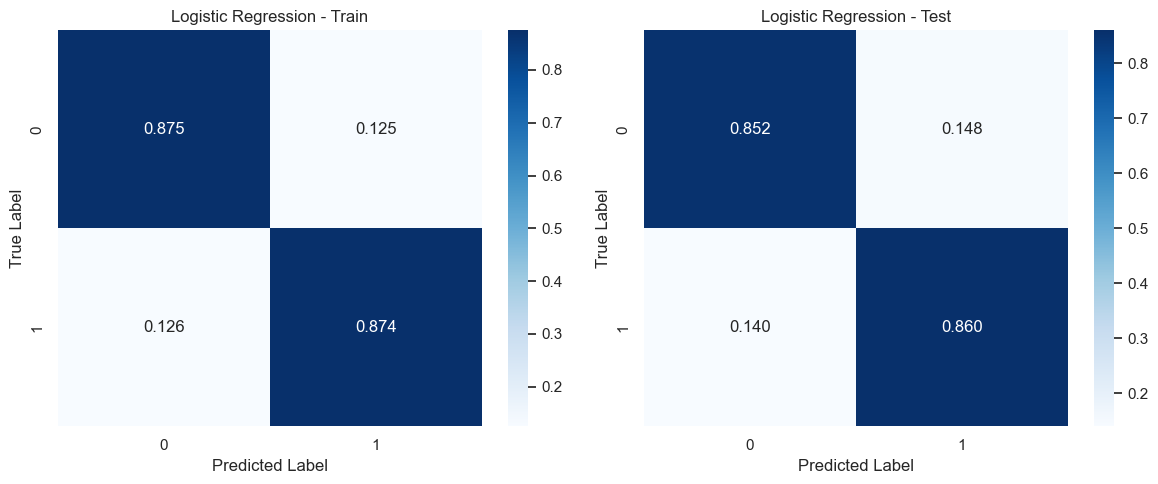

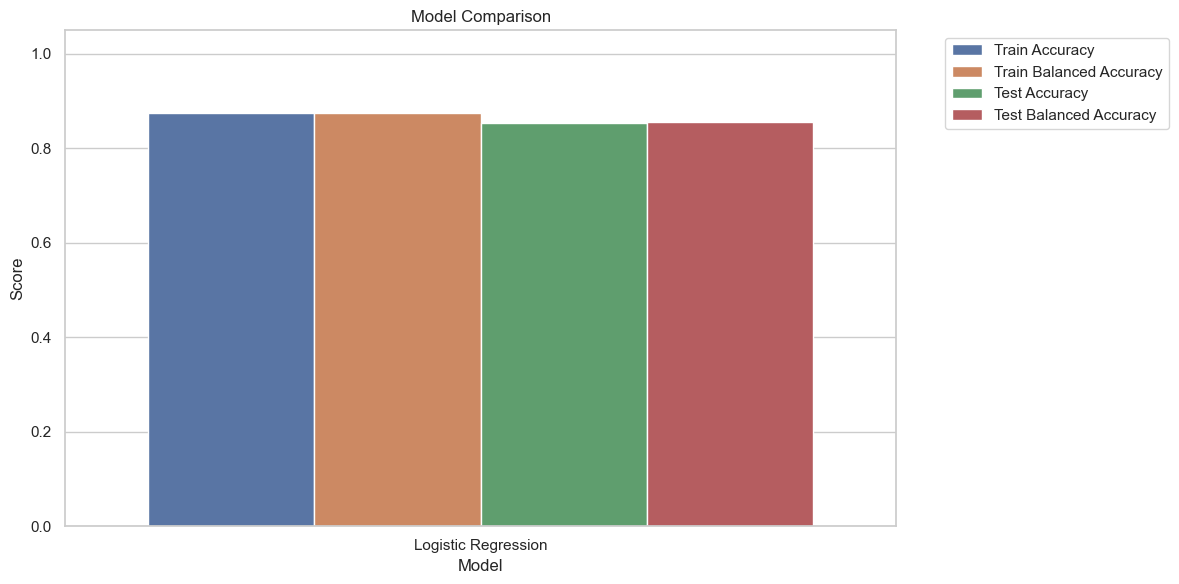





Training Logistic Regression...
Logistic Regression Training Accuracy: 0.8805
Logistic Regression Training Balanced Accuracy: 0.8804
Logistic Regression Test Accuracy: 0.8531
Logistic Regression Test Balanced Accuracy: 0.8538


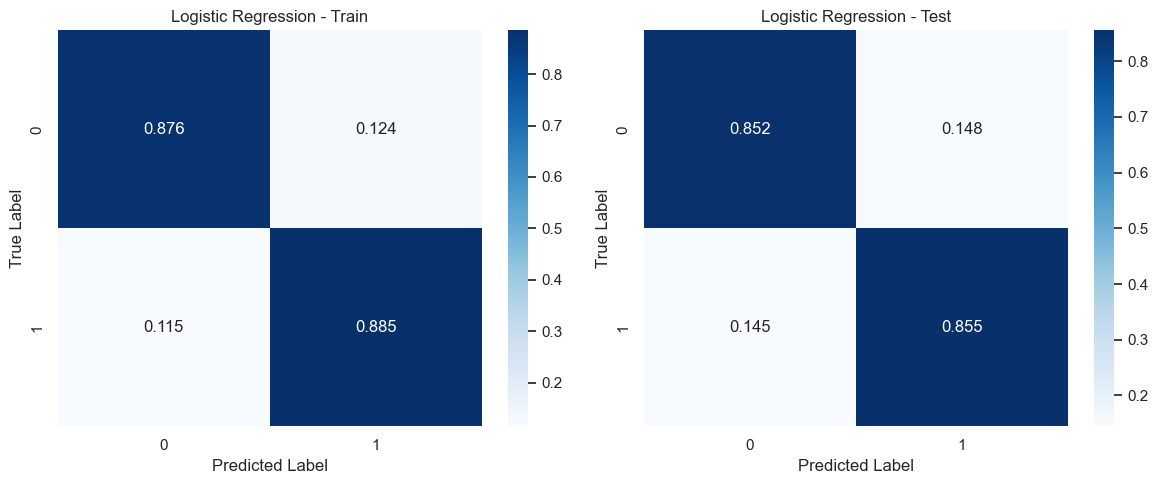

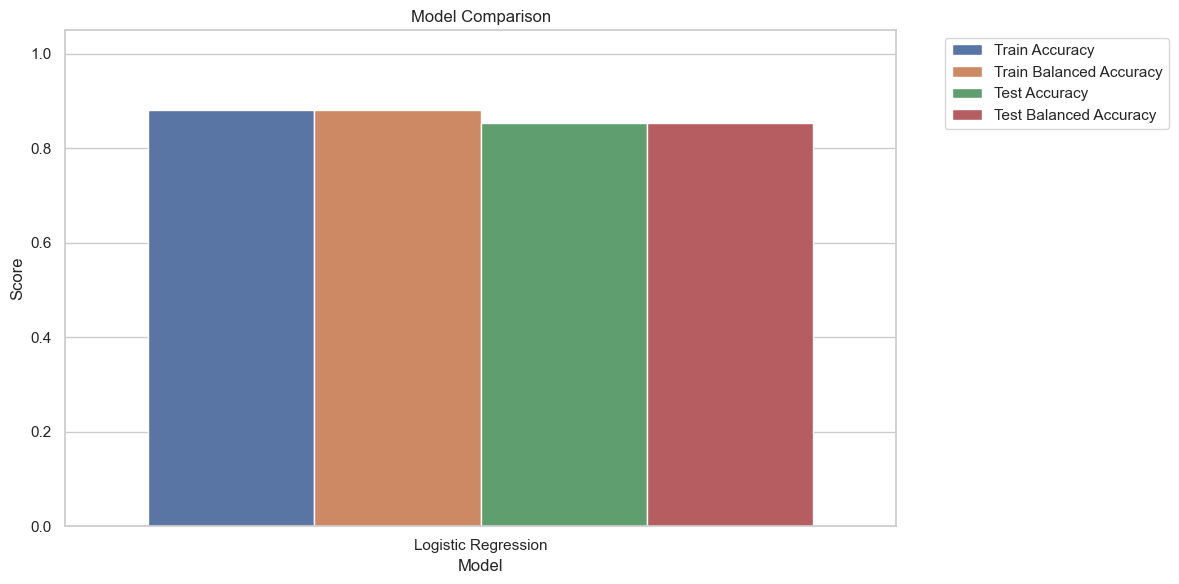





Training Logistic Regression...
Logistic Regression Training Accuracy: 0.8832
Logistic Regression Training Balanced Accuracy: 0.8831
Logistic Regression Test Accuracy: 0.8536
Logistic Regression Test Balanced Accuracy: 0.8547


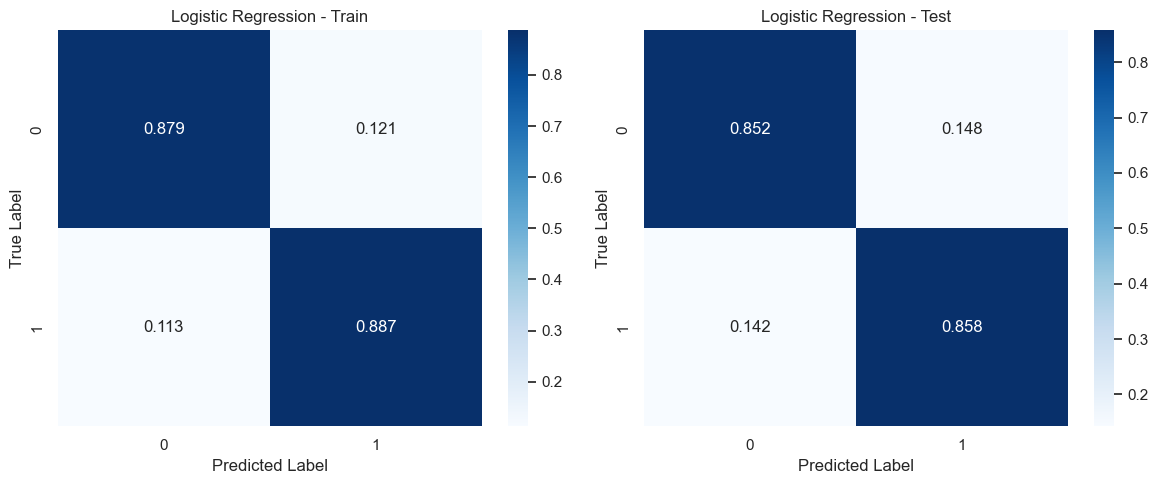

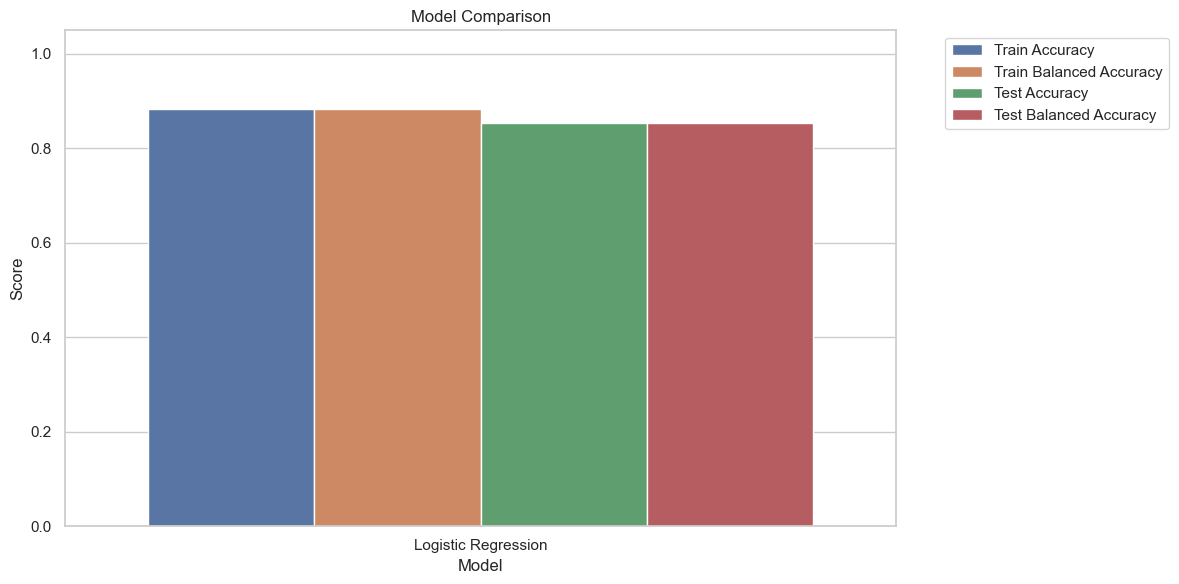

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from trainer import *

models = [
    # ('SVM', SVC(kernel='rbf', C=0.5, gamma='scale', probability=True, random_state=42)),  # n_jobs not supported
    # ('KNN', KNeighborsClassifier(n_neighbors=8, metric='minkowski', p=2, n_jobs=-1)),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)),
    # ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    # ('Naive Bayes', GaussianNB()),  # no n_jobs
]

# Convert labels to binary classification (0 vs all)
y_train_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

# Apply ADASYN for class imbalance handling
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=10)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train_binary)

for features_set in results_df["features"].tolist():
    X_train_selected = X_train_adasyn[features_set]
    X_test_selected = X_test_scaled[features_set]

    results = fit_and_evaluate_models(models, X_train_selected, y_train_adasyn, X_test_selected, y_test_binary)
    plot_model_comparison(results)
    print("\n\n")

In [12]:
X_train_nz = X_train_scaled.copy()
X_train_nz["label"] = y_train
X_train_nz["posy"] = X_train["posy"]
X_train_nz["posx"] = X_train["posx"]

X_test_new_nz = X_test_scaled.copy()
X_test_new_nz["label"] = y_test
X_test_new_nz["posx"] = X_test["posx"]
X_test_new_nz["posy"] = X_test["posy"]

X_val_new_nz = X_validation_scaled.copy()
X_val_new_nz["label"] = y_validation
X_val_new_nz["posx"] = X_validation["posx"]
X_val_new_nz["posy"] = X_validation["posy"]

# plot_features(X_train_nz, X_test_new_nz, feature_list)


Class distribution after ADASYN:
Label 0: 4608 samples (49.89%)
Label 1: 4628 samples (50.11%)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      4613
           1       0.69      0.86      0.77      1944

    accuracy                           0.84      6557
   macro avg       0.81      0.85      0.82      6557
weighted avg       0.86      0.84      0.85      6557


Train Accuracy: 0.921, Train Balanced Accuracy: 0.921
Test Accuracy: 0.843, Test Balanced Accuracy: 0.849


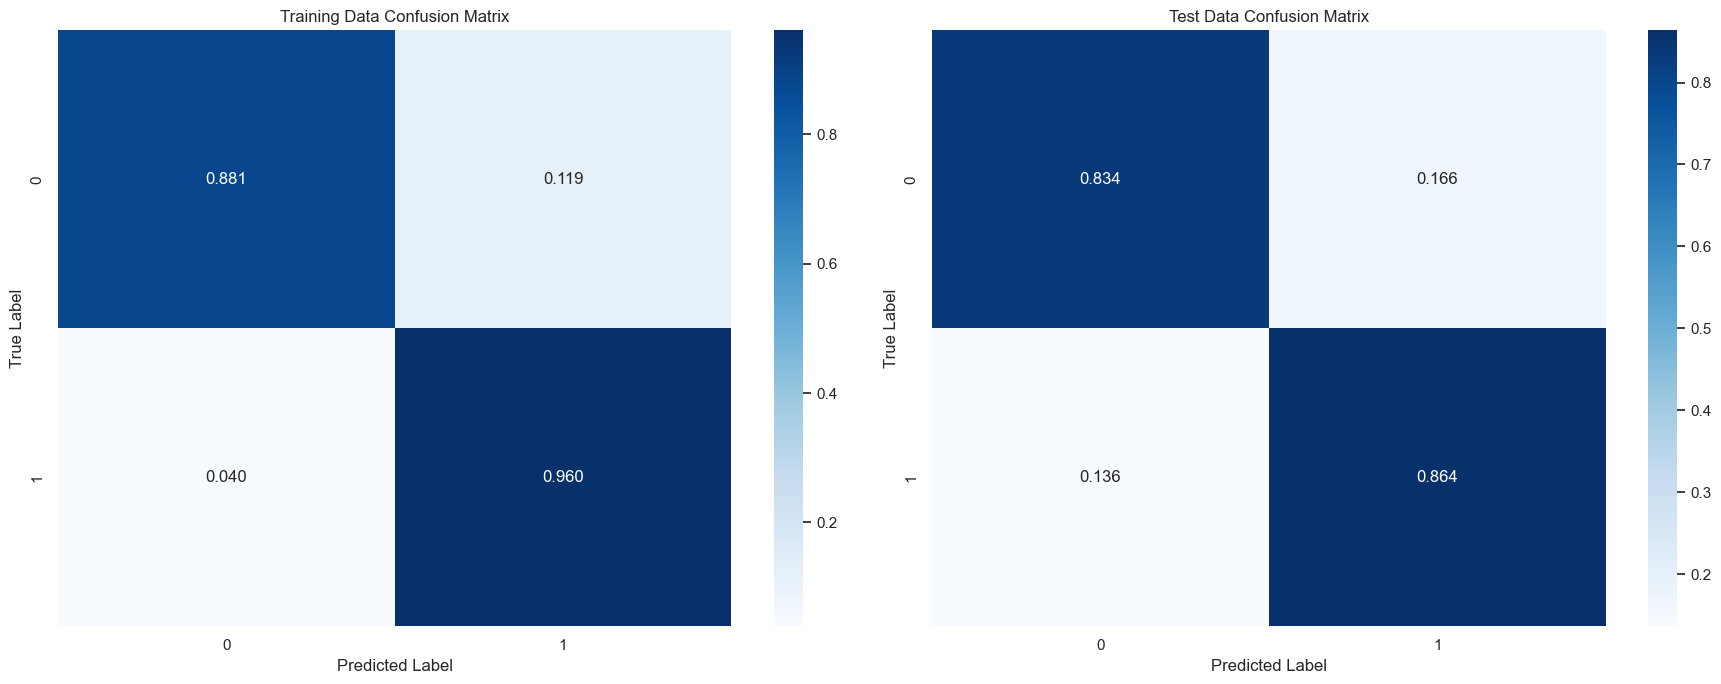

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score

# Create dataset with selected features (excluding posx, posy)
# X_train_selected = X_train[feature_list]
# X_test_selected = X_test[feature_list]

feature_list = results_df["features"][2]

X_train_selected = X_train_scaled[feature_list]
X_test_selected = X_test_scaled[feature_list]
X_validation_selected = X_validation_scaled[feature_list]

# Convert labels to binary classification (0 vs all)
y_train_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

# Apply ADASYN for class imbalance handling
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=10)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train_binary)
# X_train_adasyn, y_train_multi = X_train_selected, y_train

# Display new class distribution after ADASYN
adasyn_class_distribution = Counter(y_train_adasyn)
print("\nClass distribution after ADASYN:")
for label, count in sorted(adasyn_class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y_train_adasyn) * 100:.2f}%)")

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    bootstrap=True,
    criterion='entropy',
    class_weight=None,
    random_state=42,
    max_features=0.5,
    n_jobs=-1,
)

# Fit the model on binary data
rf_model.fit(X_train_adasyn, y_train_adasyn)

# Make predictions on training data
y_train_pred = rf_model.predict(X_train_adasyn)

# Make predictions on test data
y_test_pred = rf_model.predict(X_test_selected)

y_validation_pred = rf_model.predict(X_validation_selected)

# Evaluate the model on test data
print("\nClassification Report (Test Data):")
print(classification_report(y_test_binary, y_test_pred, zero_division=0))

# Calculate performance metrics
test_accuracy = accuracy_score(y_test_binary, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test_binary, y_test_pred)
train_accuracy = accuracy_score(y_train_adasyn, y_train_pred)
train_balanced_acc = balanced_accuracy_score(y_train_adasyn, y_train_pred)

print(f"\nTrain Accuracy: {train_accuracy:.3f}, Train Balanced Accuracy: {train_balanced_acc:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}, Test Balanced Accuracy: {test_balanced_acc:.3f}")


# Function to create and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)  # Replace NaN with 0

    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1], ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')


# Create a figure with two subplots for the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot confusion matrices for training and test data
plot_confusion_matrix(y_train_adasyn, y_train_pred, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_test_binary, y_test_pred, 'Test Data Confusion Matrix', ax2)

plt.tight_layout()
plt.show()

In [14]:
hard_spots_test_index = y_test_pred == 1
hard_spots_test = X_test_new_nz[hard_spots_test_index]
y_test_hard = y_test[hard_spots_test_index]

hard_spots_val_index = y_validation != 0
hard_spots_validation = X_val_new_nz[hard_spots_val_index]
y_validation_hard = y_validation[hard_spots_val_index]

# y_train_pred = rf_model.predict(X_train[feature_list])
hard_spots_train_index = y_train != 0
hard_spots_train = X_train_nz[hard_spots_train_index]
y_train_hard = y_train[hard_spots_train_index]

In [15]:
from plotter import *


def grid_max_smooth(df, features_to_smooth, grid_range=1):
    """
    Efficiently smooth each feature using a 3x3 grid around each point.
    """
    df_smoothed = df.copy()

    # Create a spatial index - a dictionary mapping (x,y) to row index position O(1) - instead of repeated search
    spatial_index = {}
    for i, (idx, row) in enumerate(df.iterrows()):
        spatial_index[(row['posx'], row['posy'])] = i

    # Process each feature
    for feature in features_to_smooth:
        if feature not in df.columns or feature in ['posx', 'posy', 'label']:
            continue

        feature_values = df[feature].values  # Cache the feature values array
        smoothed_values = np.empty_like(feature_values)

        # For each position in the original dataframe
        for i, (idx, row) in enumerate(df.iterrows()):
            x, y = row['posx'], row['posy']
            grid_values = []

            # Check each cell in the 3x3 grid
            for dx in range(-grid_range, grid_range + 1):
                for dy in range(-grid_range, grid_range + 1):
                    # Use the spatial index for direct lookup
                    grid_pos = (x + dx, y + dy)
                    if grid_pos in spatial_index:
                        pos = spatial_index[grid_pos]
                        grid_values.append(feature_values[pos])

            # Take the maximum of the values found in the grid
            smoothed_values[i] = max(grid_values) if grid_values else feature_values[i]

        # Assign all values at once
        df_smoothed[feature] = smoothed_values

    return df_smoothed


# Apply kNN median smoothing to train set
hard_spots_train_smoothed = grid_max_smooth(
    hard_spots_train,
    feature_list,
)

# Apply kNN median smoothing to test set
hard_spots_test_smoothed = grid_max_smooth(
    hard_spots_test,
    feature_list,
)

# Apply kNN median smoothing to validation set
hard_spots_validation_smoothed = grid_max_smooth(
    hard_spots_validation,
    feature_list,
)

# # Visualize the smoothing effect for each feature
# for feature in feature_list:
#     plot_smoothing_effect(
#         hard_spots_test,
#         hard_spots_test_smoothed,
#         hard_spots_train,
#         hard_spots_train_smoothed,
#         feature
#     )


### Full Classifier

In [ ]:
from plotter import plot_confusion_matrix

# test_index = y_test_pred == 1
# X_test_new_nz = X_test_new[test_index]
# y_test_nz = y_test[test_index]
#
# train_index = y_train != 0
# X_train_nz = X_train[train_index]
# y_train_nz = y_train[train_index]
#
# X_train_selected = X_train_nz[feature_list]
# X_test_selected = X_test_new_nz[feature_list]  #X_test  --- X_test_new

X_train_selected = hard_spots_train_smoothed[feature_list]
X_test_selected = hard_spots_test_smoothed[feature_list]
y_train_nz = y_train_hard
y_test_nz = y_test_hard

# Apply ADASYN for adaptive oversampling
# adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)
# X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train)

X_train_adasyn, y_train_adasyn = X_train_selected, y_train_nz

# Display new class distribution after ADASYN
adasyn_class_distribution = Counter(y_train_adasyn)
print("\nClass distribution after ADASYN:")
for label, count in sorted(adasyn_class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y_train_adasyn) * 100:.2f}%)")

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    bootstrap=True,
    criterion='entropy',
    class_weight=None,
    random_state=42,
    max_features=0.5,
    n_jobs=-1,
)

# Fit the model
rf_model.fit(X_train_adasyn, y_train_adasyn)

# Make predictions on training data
y_train_pred = rf_model.predict(X_train_adasyn)

# Make predictions on test data
y_test_pred_nz = rf_model.predict(X_test_selected)

# Evaluate the model on test data
print("\nClassification Report (Test Data):")
print(classification_report(y_test_nz, y_test_pred_nz, zero_division=0))

# Calculate performance metrics
test_accuracy = accuracy_score(y_test_nz, y_test_pred_nz)
test_balanced_acc = balanced_accuracy_score(y_test_nz, y_test_pred_nz)
train_accuracy = accuracy_score(y_train_adasyn, y_train_pred)
train_balanced_acc = balanced_accuracy_score(y_train_adasyn, y_train_pred)

# Create a figure with two subplots for the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot confusion matrices for training and test data
plot_confusion_matrix(y_train_adasyn, y_train_pred, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_test_nz, y_test_pred_nz, 'Test Data Confusion Matrix', ax2)

plt.tight_layout()
plt.show()


In [ ]:
from plotter import plot_confusion_matrix

test_index = y_test_pred == 1
X_test_new_nz = X_test_scaled[test_index]
y_test_nz = y_test[test_index]

train_index = y_train != 0
X_train_nz = X_train_scaled[train_index]
y_train_nz = y_train[train_index]

X_train_selected = X_train_nz[feature_list]
X_test_selected = X_test_new_nz[feature_list]  #X_test  --- X_test_new

# X_train_selected = hard_spots_train_smoothed[feature_list]
# X_test_selected = hard_spots_test_smoothed[feature_list]
# y_train_nz = y_train_hard
# y_test_nz = y_test_hard

# Apply ADASYN for adaptive oversampling
# adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)
# X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train)

X_train_adasyn, y_train_adasyn = X_train_selected, y_train_nz

# Display new class distribution after ADASYN
adasyn_class_distribution = Counter(y_train_adasyn)
print("\nClass distribution after ADASYN:")
for label, count in sorted(adasyn_class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y_train_adasyn) * 100:.2f}%)")

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    bootstrap=True,
    criterion='entropy',
    class_weight=None,
    random_state=42,
    max_features=0.5,
    n_jobs=-1,
)

# Fit the model
rf_model.fit(X_train_adasyn, y_train_adasyn)

# Make predictions on training data
y_train_pred = rf_model.predict(X_train_adasyn)

# Make predictions on test data
y_test_pred_nz = rf_model.predict(X_test_selected)

# Evaluate the model on test data
print("\nClassification Report (Test Data):")
print(classification_report(y_test_nz, y_test_pred_nz, zero_division=0))

# Calculate performance metrics
test_accuracy = accuracy_score(y_test_nz, y_test_pred_nz)
test_balanced_acc = balanced_accuracy_score(y_test_nz, y_test_pred_nz)
train_accuracy = accuracy_score(y_train_adasyn, y_train_pred)
train_balanced_acc = balanced_accuracy_score(y_train_adasyn, y_train_pred)

# Create a figure with two subplots for the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot confusion matrices for training and test data
plot_confusion_matrix(y_train_adasyn, y_train_pred, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_test_nz, y_test_pred_nz, 'Test Data Confusion Matrix', ax2)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import numpy as np


class TwoStageClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, binary_model=None, multiclass_model=None, features=None, train_smoothed=None):
        self.binary_model = binary_model
        self.multiclass_model = multiclass_model
        self.features = features
        self.train_smoothed = train_smoothed

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y_binary = (y != 0).astype(int)
        mask = y != 0

        adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=10)
        X_adasyn, y_binary_adasyn = adasyn.fit_resample(X[self.features], y_binary)

        self.binary_model_ = clone(self.binary_model)
        self.binary_model_.fit(X_adasyn, y_binary_adasyn)

        self.multiclass_model_ = clone(self.multiclass_model)
        y_multiclass = y[mask] - 1

        if len(self.train_smoothed[0]) == len(y_multiclass):
            X_hard_smoothed = self.train_smoothed[0][self.features]
        else:
            X_hard_smoothed = self.train_smoothed[1][self.features]

        self.multiclass_model_.fit(X_hard_smoothed, y_multiclass)
        return self

    def predict(self, X):
        binary_preds = self.binary_model_.predict(X[self.features])
        idx = binary_preds == 1

        X_hard_smoothed = grid_max_smooth(
            X[idx],
            self.features
        )

        final_preds = np.zeros(X.shape[0], dtype=int)
        if np.any(idx):
            final_preds[idx] = self.multiclass_model_.predict(X_hard_smoothed[self.features]) + 1

        return final_preds

In [ ]:
# List of model hyperparameters definitions
models = [
    {
        'model': SVC(kernel='rbf'),
        'hyperparameters': {
            'C': [20, 25, 30],
            'gamma': [0.06, 0.1, 0.2],
        }
    },
    {
        'model': RandomForestClassifier(n_jobs=-1, bootstrap=True, criterion='entropy', max_features=0.5,
                                        n_estimators=200),
        'hyperparameters': {
            'max_depth': [None],
            'min_samples_split': [6, 10, 15],
            'min_samples_leaf': [5, 8]
        }
    }
    #   {
    #         'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    #         'hyperparameters': {
    #             'n_estimators': [100, 200],
    #             'max_depth': [4, 6],
    #             'gamma': [i / 10.0 for i in range(0, 4)]
    #         }
    #     }
]

from itertools import product


# Function to generate all combinations of binary and multiclass classifiers
def generate_combinations(models):
    combinations = []

    # Generate combinations for binary and multiclass model pairs
    for binary_model, multiclass_model in product(models, repeat=2):
        binary_model_params = binary_model['hyperparameters']
        multiclass_model_params = multiclass_model['hyperparameters']

        # Construct a dict for each combination
        param_dict = {
            'binary_model': [binary_model['model']],
            **{f'binary_model__{k}': v for k, v in binary_model_params.items()},
            'multiclass_model': [multiclass_model['model']],
            **{f'multiclass_model__{k}': v for k, v in multiclass_model_params.items()},
            'features': list(results_df['features'])
        }

        combinations.append(param_dict)

    return combinations


# Generate the combinations
param_grid = generate_combinations(models)
param_grid

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

clf = TwoStageClassifier(train_smoothed=[hard_spots_train_smoothed, hard_spots_validation_smoothed])

X_train_final = X_train_scaled.copy()
X_train_final["posy"] = X_train["posy"]
X_train_final["posx"] = X_train["posx"]

X_test_final = X_test_scaled.copy()
X_test_final["posx"] = X_test["posx"]
X_test_final["posy"] = X_test["posy"]

X_val_final = X_validation_scaled.copy()
X_val_final["posx"] = X_validation["posx"]
X_val_final["posy"] = X_validation["posy"]

X_train_val = pd.concat([X_train_final, X_val_final], axis=0)
y_train_val = pd.concat([y_train, y_validation], axis=0)

test_fold = [0] * len(X_train_final) + [1] * len(X_val_final)
ps = PredefinedSplit(test_fold)

grid_search = GridSearchCV(
    clf,
    param_grid,
    scoring=make_scorer(f1_score, average='macro'),
    error_score='raise',
    cv=ps,
    n_jobs=-1,
    refit=False,
    verbose=3
)

grid_search.fit(X_train_val, y_train_val)
print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [ ]:
def print_metrics(y_true, y_pred, label="Set"):
    print(f"\n=== {label} Metrics ===")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")


# Get the best parameters
best_params = grid_search.best_params_

# Create base estimators
binary_model = clone(best_params['binary_model'])
multiclass_model = clone(best_params['multiclass_model'])
best_features = best_params['features'] + ["posx", "posy"]

# Apply parameters to the two models
for param, value in best_params.items():
    if param.startswith('binary_model__'):
        param_name = param.replace('binary_model__', '')
        setattr(binary_model, param_name, value)
    if param.startswith('multiclass_model__'):
        param_name = param.replace('multiclass_model__', '')
        setattr(multiclass_model, param_name, value)

# Create classifier with the configured models
best_clf = TwoStageClassifier(
    binary_model=binary_model,
    multiclass_model=multiclass_model,
    features=best_params['features'],
    train_smoothed=[hard_spots_train_smoothed, hard_spots_validation_smoothed]
)

# Now fit and evaluate as before
best_clf.fit(X_train_final[best_features], y_train)

# Make predictions
y_pred_test = best_clf.predict(X_test_final[best_features])
y_pred_train = best_clf.predict(X_train_final[best_features])
y_pred_val = best_clf.predict(X_val_final[best_features])

# Plot confusion matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 7))
plot_confusion_matrix(y_train, y_pred_train, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_validation, y_pred_val, 'Validation Data Confusion Matrix', ax2)
plot_confusion_matrix(y_test, y_pred_test, 'Test Data Confusion Matrix', ax3)

# Print performance metrics
print_metrics(y_test, y_pred_test, label="Test")
print_metrics(y_validation, y_pred_val, label="Validation")


## NEW PROPOSED PIPELINE

### Preparing the dataset

In [16]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
from Modeldev import *
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [20]:
scaler = StandardScaler()

df1 = X_train[feature_list_3+['posx', 'posy']]
df3 = X_test[feature_list_3+['posx', 'posy']]
df2 = X_validation[feature_list_3+['posx', 'posy']]

df1_scaled = scaler.fit_transform(df1)
df1 = pd.DataFrame(df1_scaled, columns=feature_list_3+['posx', 'posy'], index=df1.index)

df2_scaled = scaler.fit_transform(df2)
df2 = pd.DataFrame(df2_scaled, columns=feature_list_3+['posx', 'posy'], index=df2.index)

df3_scaled = scaler.fit_transform(df3)
df3 = pd.DataFrame(df3_scaled, columns=feature_list_3+['posx', 'posy'], index=df3.index)

# Assigning group
df1['group'] = 1
df2['group'] = 2
df3['group'] = 3
# For multiclass with smoothing
X_multiclass_t = hard_spots_train_smoothed.copy()
X_multiclass_t['group'] = 1

X_multiclass_v = hard_spots_validation_smoothed.copy()
X_multiclass_v['group'] = 2

y_multiclass_t = hard_spots_train_smoothed['label']
y_multiclass_v = hard_spots_validation_smoothed['label']

X_multiclass_train = pd.concat([X_multiclass_t, X_multiclass_v], axis=0, ignore_index=True)
y_multiclass_train = np.concatenate([y_multiclass_t, y_multiclass_v])

groups_multiclass_train = X_multiclass_train['group'].to_numpy()

# Train contains the union of df1 and df2 coming from two measures with different parameters of the same object
train_df = pd.concat([df1, df2], axis=0, ignore_index=True)
y_train = y_train.to_numpy()
y_validation = y_validation.to_numpy()
X_train = train_df.drop(['group'], axis=1)
y_train = np.concatenate([y_train, y_validation])
groups_train = train_df['group'].to_numpy()  # Convert to NumPy array

# Test will be done on a new object
X_test = df3.drop(['group'], axis=1)
y_test = y_test.to_numpy()
groups_test = df3['group'].to_numpy()  # Convert to NumPy array

# Define feature sets
feature_sets = results_df["features"].tolist()
# Define classifier types
classifier_types = ['rf', 'xgb', 'logistic', 'gb']

### Model Selection + Hyperparameter Tuning using cv

In [21]:
n_splits = 5  # Number of splits
n_trials = 15  # Number of Optuna trials
# Define ADASYN for oversampling
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=10)
# Define fold method
group_kfold = StratifiedKFold( n_splits=n_splits)


# PHASE 1: Find the best binary classifier
# Initialize variables to track the best binary model
best_binary_feature_set = None
best_binary_classifier_type = None
best_binary_params = None
best_binary_f1 = -1

# Create binary labels (0 vs. >0)
y_binary = (y_train > 0).astype(int)

print("Finding the best binary classifier")
for feature_set in feature_sets:
    print(f"Processing feature set: {feature_set}")

    # Extract features for this set
    X_selected_train = X_train[feature_set]

    for clf_type in classifier_types:
        print(f"  Classifier: {clf_type}")

        # Create study for binary classifier
        study = optuna.create_study(direction='maximize')

        # Define objective function for the classifier type
        if clf_type == 'rf':
            objective = lambda trial: objective_rf(
                trial, X_selected_train, y_binary, groups_train,
                group_kfold,adasyn
            )
        elif clf_type == 'svc':
            objective = lambda trial: objective_svc(
                trial, X_selected_train, y_binary, groups_train,
                group_kfold,adasyn
            )
        elif clf_type == 'xgb':
            objective = lambda trial: objective_xgb(
                trial, X_selected_train, y_binary, groups_train,
                group_kfold,adasyn
            )
        elif clf_type == 'logistic':
            objective = lambda trial: objective_logistic(
                trial, X_selected_train, y_binary, groups_train,
                group_kfold,adasyn
            )
        else:  # 'gb'
            objective = lambda trial: objective_gb(
                trial, X_selected_train, y_binary, groups_train,
                group_kfold,adasyn
            )

        # Optimize classifier
        study.optimize(objective, n_trials=n_trials)
        best_params_clf = study.best_params

        # Check if this is the best model so far
        if study.best_value > best_binary_f1:
            best_binary_f1 = study.best_value
            best_binary_feature_set = feature_set
            best_binary_classifier_type = clf_type
            best_binary_params = best_params_clf

# Print best binary classifier results
print("Best binary classifier found:")
print(f"Feature set: {best_binary_feature_set}")
print(f"Classifier type: {best_binary_classifier_type}")
print(f"Parameters: {best_binary_params}")
print(f"Mean F1-score: {best_binary_f1:.4f}")


[I 2025-05-15 13:27:05,140] A new study created in memory with name: no-name-f69b12a0-3e77-4d90-a3ee-95d8666c2bc9


Finding the best binary classifier
Processing feature set: ['Stiffness']
  Classifier: rf


[I 2025-05-15 13:27:25,124] Trial 0 finished with value: 0.8616319735640058 and parameters: {'n_estimators': 411, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8616319735640058.
[I 2025-05-15 13:27:38,421] Trial 1 finished with value: 0.8548251780057786 and parameters: {'n_estimators': 238, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8616319735640058.
[I 2025-05-15 13:27:57,891] Trial 2 finished with value: 0.8568443961828172 and parameters: {'n_estimators': 383, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8616319735640058.
[I 2025-05-15 13:28:06,467] Trial 3 finished with value: 0.8523871119053874 and parameters: {'n_estimators': 146, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8616319735640058.
[I 2025-05-15 13:28:09,873] Trial 4 finished with value: 0.8597030910077702 and parameters: 

  Classifier: xgb


[I 2025-05-15 13:30:58,318] Trial 0 finished with value: 0.8597716748977422 and parameters: {'learning_rate': 0.04701548405399537, 'n_estimators': 218, 'max_depth': 9, 'subsample': 0.7881008371704445, 'colsample_bytree': 0.9131757923577164, 'min_child_weight': 7, 'gamma': 1.3710431805443664, 'reg_alpha': 8.146816213347458, 'reg_lambda': 4.83621364942239}. Best is trial 0 with value: 0.8597716748977422.
[I 2025-05-15 13:30:59,568] Trial 1 finished with value: 0.859567230716762 and parameters: {'learning_rate': 0.28093375775996837, 'n_estimators': 125, 'max_depth': 7, 'subsample': 0.7465499237425327, 'colsample_bytree': 0.8943395566087099, 'min_child_weight': 10, 'gamma': 1.049558591815634, 'reg_alpha': 9.601183188721382, 'reg_lambda': 5.990183444684872}. Best is trial 0 with value: 0.8597716748977422.
[I 2025-05-15 13:31:00,889] Trial 2 finished with value: 0.8598757170691608 and parameters: {'learning_rate': 0.28229802580887764, 'n_estimators': 165, 'max_depth': 9, 'subsample': 0.74184

  Classifier: logistic


[I 2025-05-15 13:31:19,164] Trial 0 finished with value: 0.8830415519489753 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.02016393308721988}. Best is trial 0 with value: 0.8830415519489753.
[I 2025-05-15 13:31:19,385] Trial 1 finished with value: 0.877455109392214 and parameters: {'penalty': None, 'C': 0.008203756967917381}. Best is trial 0 with value: 0.8830415519489753.
[I 2025-05-15 13:31:19,577] Trial 2 finished with value: 0.8776223101990956 and parameters: {'penalty': 'elasticnet', 'C': 16.061866301204745, 'l1_ratio': 0.013689891206378424}. Best is trial 0 with value: 0.8830415519489753.
[I 2025-05-15 13:31:19,740] Trial 3 finished with value: 0.8779145836915496 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.863197908134443}. Best is trial 0 with value: 0.8830415519489753.
[I 2025-05-15 13:31:19,900] Trial 4 finished with value: 0.8789530836536817 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.20672977360665545}. Best is trial 0

  Classifier: gb


[I 2025-05-15 13:31:44,744] Trial 0 finished with value: 0.7954142337712058 and parameters: {'learning_rate': 0.2791971610665256, 'n_estimators': 291, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 2, 'subsample': 0.9639887718995259}. Best is trial 0 with value: 0.7954142337712058.
[I 2025-05-15 13:32:01,113] Trial 1 finished with value: 0.8301011255336176 and parameters: {'learning_rate': 0.1268769903462188, 'n_estimators': 196, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 7, 'subsample': 0.6000536030263645}. Best is trial 1 with value: 0.8301011255336176.
[I 2025-05-15 13:32:07,903] Trial 2 finished with value: 0.854203569172466 and parameters: {'learning_rate': 0.03326185535751103, 'n_estimators': 58, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 9, 'subsample': 0.8647629729401318}. Best is trial 2 with value: 0.854203569172466.
[I 2025-05-15 13:32:17,838] Trial 3 finished with value: 0.8398030115176175 and parameters: {'learning_rate': 0.

Processing feature set: ['Stiffness', 'cubic_coefficient']
  Classifier: rf


[I 2025-05-15 13:34:54,524] Trial 0 finished with value: 0.8525000929413583 and parameters: {'n_estimators': 188, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8525000929413583.
[I 2025-05-15 13:35:20,149] Trial 1 finished with value: 0.8607163997732685 and parameters: {'n_estimators': 443, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8607163997732685.
[I 2025-05-15 13:35:30,545] Trial 2 finished with value: 0.8594878768314368 and parameters: {'n_estimators': 169, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8607163997732685.
[I 2025-05-15 13:35:40,501] Trial 3 finished with value: 0.8528157599343809 and parameters: {'n_estimators': 262, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8607163997732685.
[I 2025-05-15 13:36:01,004] Trial 4 finished with value: 0.8569194927825429 and parameters: {

  Classifier: xgb


[I 2025-05-15 13:38:44,217] Trial 0 finished with value: 0.8622700140733695 and parameters: {'learning_rate': 0.24339697793205814, 'n_estimators': 254, 'max_depth': 10, 'subsample': 0.6316724252382132, 'colsample_bytree': 0.8836762630729431, 'min_child_weight': 4, 'gamma': 1.241500471775433, 'reg_alpha': 3.3642834169119364, 'reg_lambda': 0.7102735710229102}. Best is trial 0 with value: 0.8622700140733695.
[I 2025-05-15 13:38:46,618] Trial 1 finished with value: 0.861470574139308 and parameters: {'learning_rate': 0.026501132513526808, 'n_estimators': 264, 'max_depth': 4, 'subsample': 0.6224160007535579, 'colsample_bytree': 0.7628252697768878, 'min_child_weight': 10, 'gamma': 3.509046008045178, 'reg_alpha': 2.1390332427522996, 'reg_lambda': 0.5224684974101224}. Best is trial 0 with value: 0.8622700140733695.
[I 2025-05-15 13:38:47,957] Trial 2 finished with value: 0.8616577173561787 and parameters: {'learning_rate': 0.1601476451175639, 'n_estimators': 89, 'max_depth': 8, 'subsample': 0.7

  Classifier: logistic


[I 2025-05-15 13:39:09,915] Trial 0 finished with value: 0.8773513472812677 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 3.074225181277223}. Best is trial 0 with value: 0.8773513472812677.
[I 2025-05-15 13:39:10,130] Trial 1 finished with value: 0.8688244519692458 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.001975038155412114}. Best is trial 0 with value: 0.8773513472812677.
[I 2025-05-15 13:39:10,377] Trial 2 finished with value: 0.8774348305702713 and parameters: {'penalty': None, 'C': 0.0014333020291404765}. Best is trial 2 with value: 0.8774348305702713.
[I 2025-05-15 13:39:10,617] Trial 3 finished with value: 0.8774348305702713 and parameters: {'penalty': None, 'C': 0.39702186913104176}. Best is trial 2 with value: 0.8774348305702713.
[I 2025-05-15 13:39:10,869] Trial 4 finished with value: 0.8774348305702713 and parameters: {'penalty': 'elasticnet', 'C': 24.22138227478156, 'l1_ratio': 0.3166041261600149}. Best is trial 2 with value: 0.8774348305702

  Classifier: gb


[I 2025-05-15 13:39:27,939] Trial 0 finished with value: 0.855645315067127 and parameters: {'learning_rate': 0.06926860551074239, 'n_estimators': 240, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 6, 'subsample': 0.8741335393055454}. Best is trial 0 with value: 0.855645315067127.
[I 2025-05-15 13:39:32,700] Trial 1 finished with value: 0.8590077561871043 and parameters: {'learning_rate': 0.1800600926570385, 'n_estimators': 54, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.654811508122545}. Best is trial 1 with value: 0.8590077561871043.
[I 2025-05-15 13:39:52,043] Trial 2 finished with value: 0.8390765545061012 and parameters: {'learning_rate': 0.18039979024970668, 'n_estimators': 136, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9, 'subsample': 0.6779940592036134}. Best is trial 1 with value: 0.8590077561871043.
[I 2025-05-15 13:40:11,994] Trial 3 finished with value: 0.8447953531956298 and parameters: {'learning_rate': 0.

Processing feature set: ['Stiffness', 'Upstroke', 'cubic_coefficient']
  Classifier: rf


[I 2025-05-15 13:43:23,742] Trial 0 finished with value: 0.8542945655498194 and parameters: {'n_estimators': 207, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8542945655498194.
[I 2025-05-15 13:43:40,851] Trial 1 finished with value: 0.8565387266466405 and parameters: {'n_estimators': 306, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8565387266466405.
[I 2025-05-15 13:43:48,486] Trial 2 finished with value: 0.8555702583872862 and parameters: {'n_estimators': 123, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8565387266466405.
[I 2025-05-15 13:44:07,788] Trial 3 finished with value: 0.8545467660620043 and parameters: {'n_estimators': 358, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8565387266466405.
[I 2025-05-15 13:44:12,588] Trial 4 finished with value: 0.8539573271099474 and parameters: {'

  Classifier: xgb


[I 2025-05-15 13:47:03,237] Trial 0 finished with value: 0.8521971132085604 and parameters: {'learning_rate': 0.20723239536666516, 'n_estimators': 58, 'max_depth': 8, 'subsample': 0.9432931481895851, 'colsample_bytree': 0.7331583867306509, 'min_child_weight': 10, 'gamma': 0.4547477130309785, 'reg_alpha': 4.275770643857884, 'reg_lambda': 3.825332301714254}. Best is trial 0 with value: 0.8521971132085604.
[I 2025-05-15 13:47:05,012] Trial 1 finished with value: 0.8482465098627028 and parameters: {'learning_rate': 0.19625406917450053, 'n_estimators': 203, 'max_depth': 7, 'subsample': 0.9005104075916333, 'colsample_bytree': 0.950489484393453, 'min_child_weight': 7, 'gamma': 4.532534008265542, 'reg_alpha': 7.661774294215316, 'reg_lambda': 6.841761081671854}. Best is trial 0 with value: 0.8521971132085604.
[I 2025-05-15 13:47:07,305] Trial 2 finished with value: 0.8533960502934104 and parameters: {'learning_rate': 0.2972037327428756, 'n_estimators': 221, 'max_depth': 3, 'subsample': 0.746304

  Classifier: logistic


[I 2025-05-15 13:47:32,360] Trial 0 finished with value: 0.8735424808386372 and parameters: {'penalty': None, 'C': 0.09700400815609882}. Best is trial 0 with value: 0.8735424808386372.
[I 2025-05-15 13:47:33,182] Trial 1 finished with value: 0.8735424808386372 and parameters: {'penalty': None, 'C': 0.010147833713617804}. Best is trial 0 with value: 0.8735424808386372.
[I 2025-05-15 13:47:34,036] Trial 2 finished with value: 0.8740090256768086 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 10.198268849506011}. Best is trial 2 with value: 0.8740090256768086.
[I 2025-05-15 13:47:34,344] Trial 3 finished with value: 0.8874963173240389 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.0021107948103107504}. Best is trial 3 with value: 0.8874963173240389.
[I 2025-05-15 13:47:35,276] Trial 4 finished with value: 0.8741717615963246 and parameters: {'penalty': 'elasticnet', 'C': 11.643558541238916, 'l1_ratio': 0.509163522682688}. Best is trial 3 with value: 0.8874963173240389.

  Classifier: gb


[I 2025-05-15 13:47:58,172] Trial 0 finished with value: 0.8493080103033679 and parameters: {'learning_rate': 0.29689632448131964, 'n_estimators': 93, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 6, 'subsample': 0.704233195504958}. Best is trial 0 with value: 0.8493080103033679.
[I 2025-05-15 13:48:16,220] Trial 1 finished with value: 0.8496010734430841 and parameters: {'learning_rate': 0.14545582016882827, 'n_estimators': 162, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 2, 'subsample': 0.7311305580900792}. Best is trial 1 with value: 0.8496010734430841.
[I 2025-05-15 13:48:40,123] Trial 2 finished with value: 0.8539980829954947 and parameters: {'learning_rate': 0.06591441682190269, 'n_estimators': 167, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6624247694886422}. Best is trial 2 with value: 0.8539980829954947.
[I 2025-05-15 13:48:54,793] Trial 3 finished with value: 0.8509244454429281 and parameters: {'learning_rate'

Best binary classifier found:
Feature set: ['Stiffness']
Classifier type: logistic
Parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.0010239283168902288}
Mean F1-score: 0.8946


In [ ]:
# PHASE 2: Find the best multiclass classifier (for samples with y > 0)
# Initialize variables to track the best multiclass model
best_multiclass_feature_set = None
best_multiclass_classifier_type = None
best_multiclass_params = None
best_multiclass_f1 = -1

print("\nPHASE 2: Finding the best multiclass classifier")
for feature_set in feature_sets:
    print(f"Processing feature set: {feature_set}")

    # Extract features for this set - only use samples with y > 0
    X_selected_multiclass_train = X_multiclass_train[feature_set]

    for clf_type in classifier_types:
        print(f"  Classifier: {clf_type}")
        # Create study for multiclass classifier
        study = optuna.create_study(direction='maximize')

        # Define objective function for the classifier type+
        if clf_type == 'rf':
            objective = lambda trial: objective_rf(
                trial, X_selected_multiclass_train, y_multiclass_train, groups_multiclass_train,
                group_kfold
            )
        elif clf_type == 'svc':
            objective = lambda trial: objective_svc(
                trial, X_selected_multiclass_train, y_multiclass_train, groups_multiclass_train,
                group_kfold
            )
        elif clf_type == 'xgb':
            objective = lambda trial: objective_xgb(
                trial, X_selected_multiclass_train, y_multiclass_train-1, groups_multiclass_train,  # This classifier needs label to start from 0
                group_kfold
            )
        elif clf_type == 'logistic':
            objective = lambda trial: objective_logistic(
                trial, X_selected_multiclass_train, y_multiclass_train, groups_multiclass_train,
                group_kfold
            )
        else:  # 'gb'
            objective = lambda trial: objective_gb(
                trial, X_selected_multiclass_train, y_multiclass_train, groups_multiclass_train,
                group_kfold
            )

        # Optimize classifier
        study.optimize(objective, n_trials=n_trials)
        best_params_clf = study.best_params

        # Check if this is the best model so far
        if study.best_value > best_multiclass_f1:
            best_multiclass_f1 = study.best_value
            best_multiclass_feature_set = feature_set
            best_multiclass_classifier_type = clf_type
            best_multiclass_params = best_params_clf

# Print best multiclass classifier results
print("Best multiclass classifier found:")
print(f"Feature set: {best_multiclass_feature_set}")
print(f"Classifier type: {best_multiclass_classifier_type}")
print(f"Parameters: {best_multiclass_params}")
print(f"Mean F1-score: {best_multiclass_f1:.4f}")


# Create binary classifier with best parameters
if best_binary_classifier_type == 'rf':
    binary_clf = RandomForestClassifier(**best_binary_params, random_state=42)
elif best_binary_classifier_type == 'svc':
    binary_clf = SVC(**best_binary_params, probability=True, random_state=42)
elif best_binary_classifier_type == 'xgb':
    binary_clf = xgb.XGBClassifier(**best_binary_params, random_state=42)
elif best_binary_classifier_type == 'logistic':
    binary_clf = LogisticRegression(**best_binary_params, random_state=42)
else:  # 'gb'
    binary_clf = GradientBoostingClassifier(**best_binary_params, random_state=42)

# Create multiclass classifier with best parameters
if best_multiclass_classifier_type == 'rf':
    multiclass_clf = RandomForestClassifier(**best_multiclass_params, random_state=42)
elif best_multiclass_classifier_type == 'svc':
    multiclass_clf = SVC(**best_multiclass_params, probability=True, random_state=42)
elif best_multiclass_classifier_type == 'xgb':
    multiclass_clf = xgb.XGBClassifier(**best_multiclass_params, random_state=42)
elif best_multiclass_classifier_type == 'logistic':
    multiclass_clf = LogisticRegression(**best_multiclass_params, random_state=42)
else:  # 'gb'
    multiclass_clf = GradientBoostingClassifier(**best_multiclass_params, random_state=42)

[I 2025-05-15 13:57:54,808] A new study created in memory with name: no-name-3bda1afc-91b8-48ba-acb2-d51ca454f313



PHASE 2: Finding the best multiclass classifier
Processing feature set: ['Stiffness']
  Classifier: rf


[I 2025-05-15 13:57:59,954] Trial 0 finished with value: 0.5281004220608955 and parameters: {'n_estimators': 299, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5281004220608955.
[I 2025-05-15 13:58:04,262] Trial 1 finished with value: 0.5264840483120103 and parameters: {'n_estimators': 251, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.5281004220608955.
[I 2025-05-15 13:58:07,049] Trial 2 finished with value: 0.5722422916681547 and parameters: {'n_estimators': 198, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.5722422916681547.
[I 2025-05-15 13:58:11,119] Trial 3 finished with value: 0.5414558744802671 and parameters: {'n_estimators': 248, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.5722422916681547.
[I 2025-05-15 13:58:12,581] Trial 4 finished with value: 0.524392608937319 and parameters: {

  Classifier: xgb


[I 2025-05-15 13:58:54,968] Trial 0 finished with value: 0.5547368351384255 and parameters: {'learning_rate': 0.16752701122535732, 'n_estimators': 162, 'max_depth': 6, 'subsample': 0.8245035279533892, 'colsample_bytree': 0.7888409909819927, 'min_child_weight': 1, 'gamma': 2.840466477546909, 'reg_alpha': 9.913168089007527, 'reg_lambda': 0.739803233904297}. Best is trial 0 with value: 0.5547368351384255.
[I 2025-05-15 13:58:56,490] Trial 1 finished with value: 0.5480349060195018 and parameters: {'learning_rate': 0.13711116556780562, 'n_estimators': 107, 'max_depth': 6, 'subsample': 0.9888990589056417, 'colsample_bytree': 0.6512167179362868, 'min_child_weight': 3, 'gamma': 3.6296769115319805, 'reg_alpha': 9.893459046227628, 'reg_lambda': 6.025060264111578}. Best is trial 0 with value: 0.5547368351384255.
[I 2025-05-15 13:58:59,011] Trial 2 finished with value: 0.5537837503340741 and parameters: {'learning_rate': 0.0770997463306657, 'n_estimators': 242, 'max_depth': 4, 'subsample': 0.97522

  Classifier: logistic


[I 2025-05-15 13:59:24,175] Trial 0 finished with value: 0.5644177080552962 and parameters: {'penalty': 'elasticnet', 'C': 11.811368903392449, 'l1_ratio': 0.7758181559504329}. Best is trial 0 with value: 0.5644177080552962.
[I 2025-05-15 13:59:24,460] Trial 1 finished with value: 0.5647233872726641 and parameters: {'penalty': None, 'C': 0.0012380452688792543}. Best is trial 1 with value: 0.5647233872726641.
[I 2025-05-15 13:59:24,740] Trial 2 finished with value: 0.565171832703126 and parameters: {'penalty': 'elasticnet', 'C': 0.9084597482275933, 'l1_ratio': 0.32007527116239887}. Best is trial 2 with value: 0.565171832703126.
[I 2025-05-15 13:59:25,013] Trial 3 finished with value: 0.5647233872726641 and parameters: {'penalty': None, 'C': 0.12686476591574578}. Best is trial 2 with value: 0.565171832703126.
[I 2025-05-15 13:59:25,286] Trial 4 finished with value: 0.5647233872726641 and parameters: {'penalty': None, 'C': 30.92702497853637}. Best is trial 2 with value: 0.565171832703126.


  Classifier: gb


[I 2025-05-15 13:59:31,716] Trial 0 finished with value: 0.5317674325379114 and parameters: {'learning_rate': 0.0629083592947977, 'n_estimators': 76, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 4, 'subsample': 0.7139092297235687}. Best is trial 0 with value: 0.5317674325379114.
[I 2025-05-15 13:59:39,905] Trial 1 finished with value: 0.5265878674354989 and parameters: {'learning_rate': 0.01486788451661097, 'n_estimators': 102, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7, 'subsample': 0.9166103126663558}. Best is trial 0 with value: 0.5317674325379114.
[I 2025-05-15 13:59:51,505] Trial 2 finished with value: 0.46210486972191867 and parameters: {'learning_rate': 0.28441029628828857, 'n_estimators': 113, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 6, 'subsample': 0.6940631583350116}. Best is trial 0 with value: 0.5317674325379114.
[I 2025-05-15 14:00:26,310] Trial 3 finished with value: 0.4715886044955521 and parameters: {'learning_rate'

Test Set Metrics:
precision_macro: 0.5262
recall_macro: 0.5514
f1_macro: 0.5253
precision_class_0: 0.9350
recall_class_0: 0.9070
f1_class_0: 0.9208
precision_class_1: 0.8040
recall_class_1: 0.9304
f1_class_1: 0.8626
precision_class_2: 0.4812
recall_class_2: 0.2972
f1_class_2: 0.3674
precision_class_3: 0.4258
recall_class_3: 0.4962
f1_class_3: 0.4583
precision_class_4: 0.2083
recall_class_4: 0.1160
f1_class_4: 0.1490
precision_class_5: 0.3028
recall_class_5: 0.5619
f1_class_5: 0.3935
auc_macro: 0.9131
auc_class_0: 0.9465
auc_class_1: 0.9937
auc_class_2: 0.9423
auc_class_3: 0.9332
auc_class_4: 0.8298
auc_class_5: 0.8329


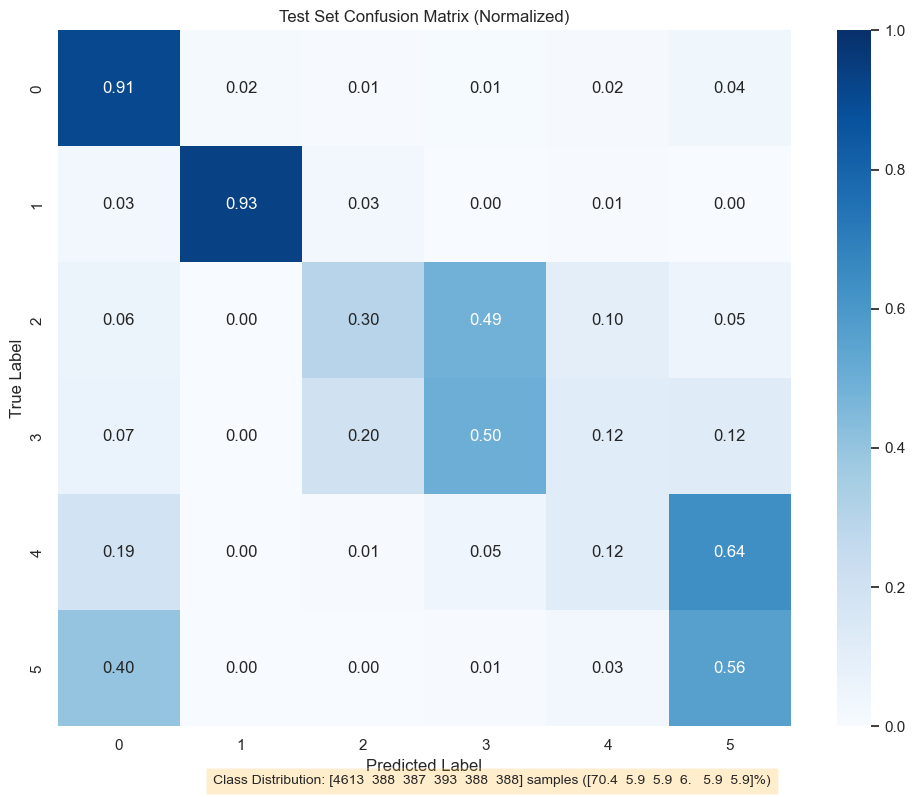

Class distribution: [4613  388  387  393  388  388]
Class percentages: [70.4  5.9  5.9  6.   5.9  5.9]%
Class 0 accuracy: 0.91
Class 1 accuracy: 0.93
Class 2 accuracy: 0.30
Class 3 accuracy: 0.50
Class 4 accuracy: 0.12
Class 5 accuracy: 0.56


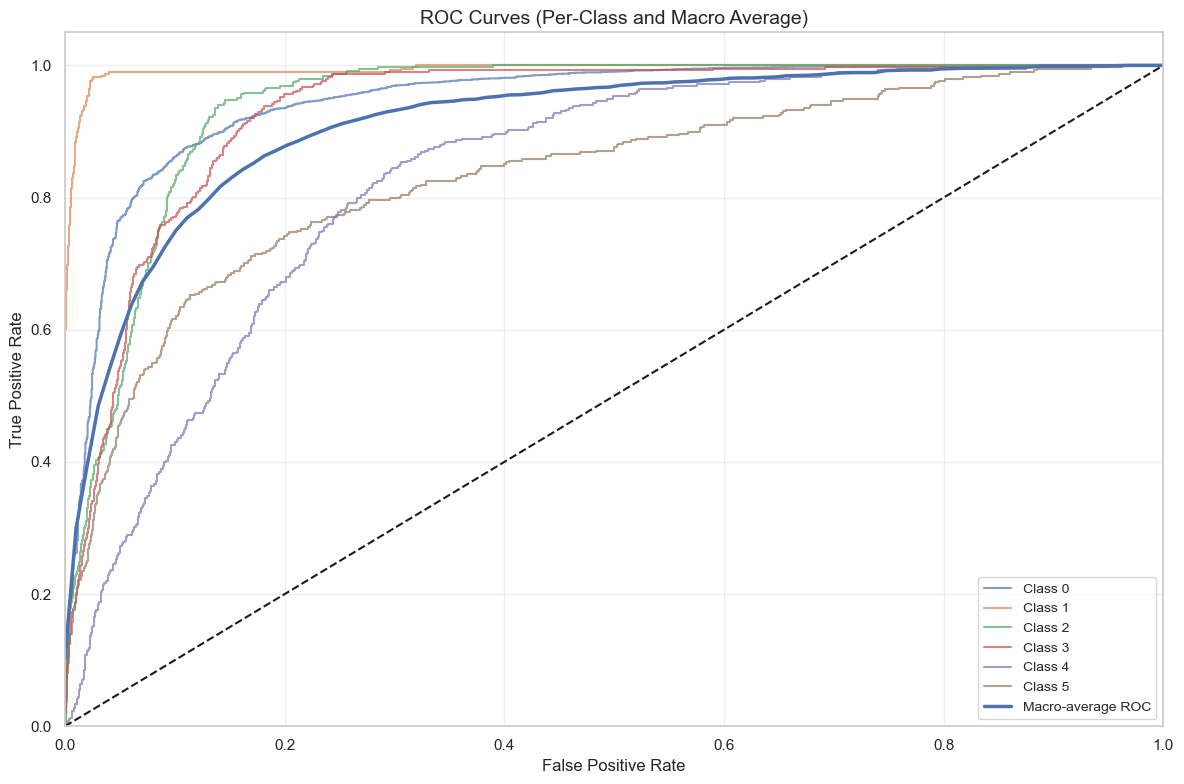

{'best_multiclass_feature_set': ['Stiffness', 'Upstroke', 'Downstroke', 'position_rms', 'elastic_coeff', 'contact_area', 'position_ptp', 'mobility', 'tkeo_mean', 'cubic_coefficient', 'stiffness_deviation_from_global_median', 'stiffness_z_score'], 'best_multiclass_classifier_type': 'svc', 'best_multiclass_params': {'C': 1.1632251518284094, 'gamma': 0.014210452291471465, 'kernel': 'linear'}, 'best_multiclass_f1': 0.770547513785406, 'best_binary_feature_set': ['Stiffness', 'Upstroke', 'Downstroke', 'position_rms', 'elastic_coeff', 'contact_area', 'position_ptp', 'mobility', 'tkeo_mean', 'cubic_coefficient', 'stiffness_deviation_from_global_median', 'stiffness_z_score'], 'best_binary_classifier_type': 'gb', 'best_binary_params': {'learning_rate': 0.16019579623086672, 'n_estimators': 267, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 9, 'subsample': 0.6606707400487802}, 'best_binary_f1': 0.9070976479051959, 'test_metrics': {'precision_macro': np.float64(0.5261713045155131), 'r

In [25]:
# Create and train the best two-stage classifier
complete_model = TwoStageClassifier(binary_clf, multiclass_clf, best_binary_feature_set, best_multiclass_feature_set, binary_unbalanced = True, train_smoothed = X_multiclass_train)
complete_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_test = complete_model.predict(X_test)
y_proba_test = complete_model.predict_proba(X_test)

test_metrics = calculate_metrics(y_test, y_pred_test, y_proba_test)

# Print final results
print("Test Set Metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

plot_confusion_matrix(y_test, y_pred_test, title='Test Set Confusion Matrix')

# Plot ROC curves
all_classes = np.unique(np.concatenate([y_train, y_test]))
plot_roc_curves(y_test, y_proba_test, all_classes)

# Return summary of results
summary = {
    'best_multiclass_feature_set' : best_multiclass_feature_set,
    'best_multiclass_classifier_type' : best_multiclass_classifier_type,
    'best_multiclass_params' : best_multiclass_params,
    'best_multiclass_f1' : best_multiclass_f1,
    'best_binary_feature_set' : best_binary_feature_set,
    'best_binary_classifier_type' : best_binary_classifier_type,
    'best_binary_params' : best_binary_params,
    'best_binary_f1' : best_binary_f1,
    'test_metrics': test_metrics,
    'model': complete_model
}

print(summary)

### SINGLE CLASSIFIER MODEL

In [26]:
n_splits = 4  # Number of splits will be doubled  => split per object (object n: 2)
n_trials = 20  # Number of Optuna trials
# Define ADASYN for oversampling
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=10)
# Define fold method
group_kfold = StratifiedKFold( n_splits=n_splits)
# Initialize variables
best_feature_set = None
best_classifier_type = None
best_params = None
best_f1 = -1

for feature_set in feature_sets:
    print(f"Processing feature set: {feature_set}")

    # Extract features for this set
    X_selected_train = X_train[feature_set]

    for clf_type in classifier_types:
        print(f"  Classifier: {clf_type}")

        # Create study for binary classifier
        study = optuna.create_study(direction='maximize')

        # Define objective function for the classifier type
        if clf_type == 'rf':
            objective = lambda trial: objective_rf(
                trial, X_selected_train, y_train, groups_train,
                group_kfold,adasyn
            )
        elif clf_type == 'svc':
            objective = lambda trial: objective_svc(
                trial, X_selected_train, y_train, groups_train,
                group_kfold,adasyn
            )
        elif clf_type == 'xgb':
            objective = lambda trial: objective_xgb(
                trial, X_selected_train, y_train, groups_train,
                group_kfold,adasyn
            )
        elif clf_type == 'logistic':
            objective = lambda trial: objective_logistic(
                trial, X_selected_train, y_train, groups_train,
                group_kfold,adasyn
            )
        else:  # 'gb'
            objective = lambda trial: objective_gb(
                trial, X_selected_train, y_train, groups_train,
                group_kfold,adasyn
            )

        # Optimize classifier
        study.optimize(objective, n_trials=n_trials)
        best_params_clf = study.best_params

        # Check if this is the best model so far
        if study.best_value > best_f1:
            best_f1 = study.best_value
            best_feature_set = feature_set
            best_classifier_type = clf_type
            best_params = best_params_clf

# Print best binary classifier results
print("Best binary classifier found:")
print(f"Feature set: {best_feature_set}")
print(f"Classifier type: {best_classifier_type}")
print(f"Parameters: {best_params}")
print(f"Mean F1-score: {best_f1:.4f}")

[I 2025-05-15 10:00:55,392] A new study created in memory with name: no-name-25a02505-ab4f-4267-a6e5-5b86a0466e41


Finding the best binary classifier
Processing feature set: ['Upstroke', 'Downstroke']
  Classifier: rf


[I 2025-05-15 10:01:05,063] Trial 0 finished with value: 0.433503199021422 and parameters: {'n_estimators': 126, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.433503199021422.
[W 2025-05-15 10:01:41,566] Trial 1 failed with parameters: {'n_estimators': 366, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "D:\Anaconda\envs\DMML\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Luca\AppData\Local\Temp\ipykernel_16312\915579804.py", line 29, in <lambda>
    objective = lambda trial: objective_rf(
                              ^^^^^^^^^^^^^
  File "D:\Artificial touch\Modeldev.py", line 339, in objective_rf
    clf.fit(X_train, y_train)
  File "D:\Anaconda\envs\DMML\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    ret

KeyboardInterrupt: 

In [ ]:
# Create and train the best classifier
if best_classifier_type == 'rf':
    model = RandomForestClassifier(**best_params, random_state=42)
elif best_classifier_type == 'svc':
    model = SVC(**best_binary_params, probability=True, random_state=42)
elif best_classifier_type == 'xgb':
    model = xgb.XGBClassifier(**best_params, random_state=42)
elif best_classifier_type == 'logistic':
    model = LogisticRegression(**best_params, random_state=42)
else:  # 'gb'
    model = GradientBoostingClassifier(**best_params, random_state=42)

X_train_selected, X_test_selected = X_train[best_feature_set], X_test[best_feature_set]
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_selected, y_train)
model.fit(X_train_resampled, y_train_resampled)

# Evaluate on test set
y_pred_test = model.predict(X_test_selected)
y_proba_test = model.predict_proba(X_test_selected)

test_metrics = calculate_metrics(y_test, y_pred_test, y_proba_test)

# Print final results
print("Test Set Metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

plot_confusion_matrix(y_test, y_pred_test, title='Test Set Confusion Matrix')

# Plot ROC curves
all_classes = np.unique(np.concatenate([y_train, y_test]))
plot_roc_curves(y_test, y_proba_test, all_classes)

# Return summary of results
summary = {
    'best_feature_set' : best_feature_set,
    'best_classifier_type' : best_classifier_type,
    'best_params' : best_params,
    'best_binary_f1' : best_f1,
    'test_metrics': test_metrics,
    'model': model
}

print(summary)

### Statistical considerations

In [27]:
def compare_distributions(X_train, X_test, feature_set):
    num_features = len(feature_set)
    cols = 3
    rows = (num_features + cols - 1) // cols  # Ceiling division for rows

    plt.figure(figsize=(5 * cols, 4 * rows))
    for i, feature in enumerate(feature_set):
        plt.subplot(rows, cols, i + 1)
        sns.kdeplot(X_train[feature], label='Train', fill=True, alpha=0.4, linewidth=2)
        sns.kdeplot(X_test[feature], label='Test', fill=True, alpha=0.4, linewidth=2, linestyle='--')
        plt.title(feature, fontsize=12)
        plt.xlabel('')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

compare_distributions(X_train, X_test, best_feature_set)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import mutual_info_score
from scipy import stats

# 1. Compare Feature Distributions
def compare_feature_distributions(X_train, X_test, feature_names=None):
    """Compare the distributions of features in train and test sets."""
    if feature_names is None:
        feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

    fig, axes = plt.subplots(len(feature_names), 2, figsize=(12, 3*len(feature_names)))

    for i, feature in enumerate(feature_names):
        # Histogram comparison
        sns.histplot(X_train[:, i] if isinstance(X_train, np.ndarray) else X_train[feature],
                     kde=True, ax=axes[i, 0], color='blue', label='Train')
        sns.histplot(X_test[:, i] if isinstance(X_test, np.ndarray) else X_test[feature],
                     kde=True, ax=axes[i, 0], color='red', alpha=0.5, label='Test')
        axes[i, 0].set_title(f'Distribution of {feature}')
        axes[i, 0].legend()

        # QQ plot to check if distributions match
        stats.probplot(X_train[:, i] if isinstance(X_train, np.ndarray) else X_train[feature],
                      dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title(f'Q-Q Plot of {feature} (Train)')

    plt.tight_layout()
    plt.show()

    # Kolmogorov-Smirnov test for distribution similarity
    ks_results = {}
    for i, feature in enumerate(feature_names):
        train_feat = X_train[:, i] if isinstance(X_train, np.ndarray) else X_train[feature]
        test_feat = X_test[:, i] if isinstance(X_test, np.ndarray) else X_test[feature]
        ks_stat, p_value = stats.ks_2samp(train_feat, test_feat)
        ks_results[feature] = {'KS Statistic': ks_stat, 'p-value': p_value}

    return pd.DataFrame(ks_results).T

# 2. Compare Feature-Class Relationships
def compare_feature_importance(X_train, y_train, X_test, y_test, feature_names=None):
    """Compare how features relate to target classes in train vs test sets."""
    if feature_names is None:
        feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

    # Method 1: Feature correlation with target
    train_correlations = []
    test_correlations = []

    for i, feature in enumerate(feature_names):
        train_feat = X_train[:, i] if isinstance(X_train, np.ndarray) else X_train[feature]
        test_feat = X_test[:, i] if isinstance(X_test, np.ndarray) else X_test[feature]

        # Point-biserial correlation for numerical features vs binary target
        if len(np.unique(y_train)) == 2:
            train_corr, _ = stats.pointbiserialr(train_feat, y_train)
            test_corr, _ = stats.pointbiserialr(test_feat, y_test)
        else:
            # For multi-class, use mutual information instead
            train_corr = mutual_info_score(train_feat, y_train)
            test_corr = mutual_info_score(test_feat, y_test)

        train_correlations.append(train_corr)
        test_correlations.append(test_corr)

    # Plot correlation comparison
    plt.figure(figsize=(10, 6))
    indices = np.arange(len(feature_names))
    width = 0.35

    plt.bar(indices - width/2, train_correlations, width, label='Train')
    plt.bar(indices + width/2, test_correlations, width, label='Test')

    plt.xlabel('Features')
    plt.ylabel('Correlation with Target')
    plt.title('Feature-Target Relationship: Train vs Test')
    plt.xticks(indices, feature_names, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate correlation between train and test correlations
    correlation_consistency = np.corrcoef(train_correlations, test_correlations)[0, 1]
    print(f"Consistency of feature-target relationships: {correlation_consistency:.4f}")

    return pd.DataFrame({
        'Feature': feature_names,
        'Train Correlation': train_correlations,
        'Test Correlation': test_correlations,
        'Absolute Difference': np.abs(np.array(train_correlations) - np.array(test_correlations))
    }).sort_values('Absolute Difference')

# 3. Class-conditional Feature Analysis
def analyze_class_conditional_features(X_train, y_train, X_test, y_test, feature_names=None):
    """Analyze feature distributions conditioned on class labels."""
    if feature_names is None:
        feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

    # Get unique classes
    classes = np.unique(np.concatenate([y_train, y_test]))

    # For each feature, compare class-conditional distributions
    results = {}

    for i, feature in enumerate(feature_names):
        train_feat = X_train[:, i] if isinstance(X_train, np.ndarray) else X_train[feature]
        test_feat = X_test[:, i] if isinstance(X_test, np.ndarray) else X_test[feature]

        # Plot class-conditional distributions
        plt.figure(figsize=(10, 6))

        for cls in classes:
            # Train data for this class
            train_cls_data = train_feat[y_train == cls]
            # Test data for this class
            test_cls_data = test_feat[y_test == cls]

            sns.kdeplot(train_cls_data, label=f'Train Class {cls}')
            sns.kdeplot(test_cls_data, label=f'Test Class {cls}', linestyle='--')

            # KS test between train and test for this class
            ks_stat, p_value = stats.ks_2samp(train_cls_data, test_cls_data)
            results.setdefault(feature, {})[f'Class {cls} KS p-value'] = p_value

        plt.title(f'Class-conditional Distribution for {feature}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return pd.DataFrame.from_dict(results, orient='index')


#Check consistency
dist_comparison = compare_feature_distributions(X_train[best_feature_set], X_test[best_feature_set], best_feature_set)
importance_comparison = compare_feature_importance(X_train[best_feature_set], y_train,
                                                  X_test[best_feature_set], y_test,
                                                 best_feature_set)
class_analysis = analyze_class_conditional_features(X_train[best_feature_set], y_train,
                                                   X_test[best_feature_set], y_test,
                                                   best_feature_set)


TypeError: object of type 'NoneType' has no len()

In [ ]:
importance_comparison

In [ ]:
dist_comparison

In [ ]:
class_analysis

In [ ]:
# Example of feature consistency analysis and interpretation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import mutual_info_score
from scipy import stats

# Let's say we've already run the analyses and want to interpret the results

# 1. Example of interpreting distribution comparison results
def interpret_distribution_results(ks_results):
    """
    Interpret the Kolmogorov-Smirnov test results.
    p-value > 0.05 suggests distributions are similar.
    """
    print("Feature Distribution Stability:")
    print("-" * 50)

    stable_features = []
    unstable_features = []

    for feature, row in ks_results.iterrows():
        if row['p-value'] > 0.05:
            stable_features.append((feature, row['p-value']))
        else:
            unstable_features.append((feature, row['p-value']))

    print("Stable features (similar distributions in train & test):")
    for feature, p_value in sorted(stable_features, key=lambda x: x[1], reverse=True):
        print(f"  - {feature}: p-value = {p_value:.4f}")

    print("\nUnstable features (different distributions in train & test):")
    for feature, p_value in sorted(unstable_features, key=lambda x: x[1]):
        print(f"  - {feature}: p-value = {p_value:.4f}")

    print("\nConclusion:")
    if len(stable_features) > len(unstable_features):
        print("Most features have stable distributions, suggesting minimal dataset shift.")
    else:
        print("Many features show different distributions, indicating possible dataset shift.")
        print("WARNING: Models trained on features with different distributions may not generalize well!")

    return stable_features, unstable_features

# 2. Example of interpreting feature-class relationship results
def interpret_feature_importance_results(importance_df, threshold=0.05):
    """
    Interpret feature importance consistency between train and test sets.
    A feature is consistently important if it ranks highly in both sets.
    """
    print("\nFeature-Class Relationship Consistency:")
    print("-" * 50)

    # Calculate the rank correlation between train and test importance
    rank_correlation = np.corrcoef(
        importance_df['Train Correlation'].rank(),
        importance_df['Test Correlation'].rank()
    )[0, 1]

    print(f"Overall rank correlation between train and test importance: {rank_correlation:.4f}")

    if rank_correlation > 0.7:
        print("Strong correlation: Features tend to maintain their relative importance across datasets.")
    elif rank_correlation > 0.4:
        print("Moderate correlation: Some variability in feature importance between datasets.")
    else:
        print("Weak correlation: Feature importance is inconsistent between datasets.")

    # Calculate relative difference
    importance_df['Relative Difference'] = np.abs(importance_df['Train Correlation'] - importance_df['Test Correlation']) / (
        (importance_df['Train Correlation'] + importance_df['Test Correlation']) / 2 + 1e-10)

    # Identify consistent vs inconsistent features
    consistent_features = importance_df[importance_df['Relative Difference'] < threshold].sort_values('Train Correlation', ascending=False)
    inconsistent_features = importance_df[importance_df['Relative Difference'] >= threshold].sort_values('Relative Difference', ascending=False)

    print(f"\nConsistently important features (appear important in both train & test):")
    if not consistent_features.empty:
        for i, row in consistent_features.head(5).iterrows():
            print(f"  - {row['Feature']}: Train={row['Train Correlation']:.4f}, Test={row['Test Correlation']:.4f}")
    else:
        print("  None found")

    print(f"\nInconsistently important features (importance differs between train & test):")
    if not inconsistent_features.empty:
        for i, row in inconsistent_features.head(5).iterrows():
            print(f"  - {row['Feature']}: Train={row['Train Correlation']:.4f}, Test={row['Test Correlation']:.4f}")
    else:
        print("  None found")

    print("\nConclusion:")
    if len(consistent_features) > len(inconsistent_features):
        print("Most features show consistent importance, suggesting good generalization potential.")
    else:
        print("Many features show inconsistent importance, suggesting possible overfitting or dataset shift.")

    return consistent_features, inconsistent_features

# 3. Example of interpreting class-conditional feature analysis
def interpret_class_conditional_results(class_results, p_value_threshold=0.05):
    """
    Interpret the class-conditional feature distribution results.
    """
    print("\nClass-Conditional Feature Stability:")
    print("-" * 50)

    stable_by_class = {}
    unstable_by_class = {}

    for feature, row in class_results.iterrows():
        for col in row.index:
            if 'KS p-value' in col:
                class_label = col.split(' KS')[0]
                p_value = row[col]

                if p_value > p_value_threshold:
                    stable_by_class.setdefault(class_label, []).append((feature, p_value))
                else:
                    unstable_by_class.setdefault(class_label, []).append((feature, p_value))

    for class_label in sorted(stable_by_class.keys()):
        print(f"\n{class_label} - Stable features:")
        for feature, p_value in sorted(stable_by_class[class_label], key=lambda x: x[1], reverse=True)[:5]:
            print(f"  - {feature}: p-value = {p_value:.4f}")

    for class_label in sorted(unstable_by_class.keys()):
        print(f"\n{class_label} - Unstable features:")
        for feature, p_value in sorted(unstable_by_class[class_label], key=lambda x: x[1])[:5]:
            print(f"  - {feature}: p-value = {p_value:.4f}")

    # Find features that are stable across all classes
    all_classes = set(stable_by_class.keys()).union(set(unstable_by_class.keys()))
    all_features = set()
    for features in stable_by_class.values():
        all_features.update([f[0] for f in features])

    universally_stable = []
    for feature in all_features:
        stable_for_all_classes = True
        for class_label in all_classes:
            stable_class_features = [f[0] for f in stable_by_class.get(class_label, [])]
            if feature not in stable_class_features:
                stable_for_all_classes = False
                break
        if stable_for_all_classes:
            universally_stable.append(feature)

    print(f"\nFeatures stable across ALL classes:")
    for feature in universally_stable:
        print(f"  - {feature}")

    print("\nConclusion:")
    if universally_stable:
        print(f"Found {len(universally_stable)} features that are reliable indicators across all classes.")
        print("These features are most likely to generalize well as predictors.")
    else:
        print("No features are consistently stable across all classes.")
        print("Consider class-specific feature sets or more robust modeling approaches.")

    return universally_stable, stable_by_class, unstable_by_class

# 4. Combine all analyses for overall interpretation
def identify_reliable_features(distribution_results, importance_results, class_results,
                              p_value_threshold=0.05, importance_threshold=0.05):
    """
    Combine all analyses to identify the most reliable features.
    """
    # Get stable features from distribution analysis
    stable_dist, _ = interpret_distribution_results(distribution_results)
    stable_dist_features = [f[0] for f in stable_dist]

    # Get consistent features from importance analysis
    consistent_features, _ = interpret_feature_importance_results(
        importance_results, threshold=importance_threshold
    )
    consistent_imp_features = consistent_features['Feature'].tolist()

    # Get universally stable features from class-conditional analysis
    universally_stable, _, _ = interpret_class_conditional_results(
        class_results, p_value_threshold=p_value_threshold
    )

    # Find features that pass all three tests
    reliable_features = set(stable_dist_features).intersection(
        set(consistent_imp_features)).intersection(set(universally_stable))

    print("\n" + "="*50)
    print("OVERALL CONCLUSION")
    print("="*50)
    print(f"Found {len(reliable_features)} highly reliable features that pass all tests:")
    for feature in reliable_features:
        print(f"  - {feature}")

    print("\nThese features:")
    print("1. Have similar distributions in train and test sets")
    print("2. Show consistent importance for prediction in both datasets")
    print("3. Maintain their class-conditional behavior across datasets")
    print("\nRECOMMENDATION: Consider focusing on these features for your final model")

    # Also identify features that pass 2 out of 3 tests
    partially_reliable = set()
    partially_reliable.update(
        set(stable_dist_features).intersection(set(consistent_imp_features)))
    partially_reliable.update(
        set(stable_dist_features).intersection(set(universally_stable)))
    partially_reliable.update(
        set(consistent_imp_features).intersection(set(universally_stable)))
    partially_reliable = partially_reliable - reliable_features

    print(f"\nAdditionally found {len(partially_reliable)} partially reliable features (passing 2/3 tests):")
    for feature in partially_reliable:
        print(f"  - {feature}")

    return reliable_features, partially_reliable

stable_features, unstable_features = interpret_distribution_results(dist_comparison)
consistent_features, inconsistent_features = interpret_feature_importance_results(importance_comparison)
universally_stable, stable_by_class, unstable_by_class = interpret_class_conditional_results(class_analysis)
reliable_features, partially_reliable = identify_reliable_features(dist_comparison, importance_comparison, class_analysis)
